In [21]:
import numpy as np
import pandas as pd
import os
import dill
import pathos
import matplotlib
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.constants as cts
from scipy.interpolate import interp2d, RectBivariateSpline
from scipy.integrate import odeint, solve_ivp
print(plt.get_backend())
# import sys
# print(sys.path)
import pylcp
import pylcp.rateeq
from pylcp.fields import (magField, quadrupoleMagneticField, conventional3DMOTBeams,
                          infinitePlaneWaveBeam, gaussianBeam, clippedGaussianBeam)
from pylcp.gratings import maskedGaussianGratingMOTBeams, infiniteGratingMOTBeams
import time
plt.style.use('paper')
savefigs = False

"""
Note on units:
Frequencies are in units of natural linewidths
So, Doppler and Zeeman shifts are also in units of linewidths.
Therefore, distances are in units of (Gamma/(mu_B dB_z')) and velocities are in units of (Gamma/k).
"""

nbAgg


"\nNote on units:\nFrequencies are in units of natural linewidths\nSo, Doppler and Zeeman shifts are also in units of linewidths.\nTherefore, distances are in units of (Gamma/(mu_B dB_z')) and velocities are in units of (Gamma/k).\n"

# **Blue MOT analysis:**

## Specify Parameters

In [22]:
"""
First, let's specify the atomic physics:
"""
axis_list = ['x','y','z']
species_list = ["$^{88}$Sr", "$^{87}$Sr", "$^{174}$Yb", "$^{171}$Yb"]
nuclear_spin = {"$^{88}$Sr":0, "$^{87}$Sr":9/2, "$^{174}$Yb":0, "$^{171}$Yb":1/2}
Ahfs = {"$^{88}$Sr":0, "$^{87}$Sr":-3.4e6, "$^{174}$Yb":0, "$^{171}$Yb":-213e6}
Bhfs = {"$^{88}$Sr":0, "$^{87}$Sr":39e6, "$^{174}$Yb":0, "$^{171}$Yb":0}
gJ = {"$^{88}$Sr":1, "$^{87}$Sr":1, "$^{174}$Yb":1, "$^{171}$Yb":1}
tau = {"$^{88}$Sr":5.22e-9, "$^{87}$Sr":5.22e-9,
       "$^{174}$Yb":1/(2*np.pi*29*10**6),"$^{171}$Yb":1/(2*np.pi*29*10**6)} # excited state lifetime
# NIST database is down, so I'm using Yb numbers from Stellmer's thesis for the moment.
gamma = {"$^{88}$Sr":1/5.22e-9, "$^{87}$Sr":1/5.22e-9,
         "$^{174}$Yb":2*np.pi*29*10**6, "$^{171}$Yb":2*np.pi*29*10**6} # from PRL 94, 083004 and PRA 73, 011403(R)
gammaHz = {"$^{88}$Sr":1/(2*np.pi*5.22e-9), "$^{87}$Sr":1/(2*np.pi*5.22e-9),
           "$^{174}$Yb":29*10**6, "$^{171}$Yb":29*10**6}
m = {"$^{88}$Sr":88*cts.value('atomic mass constant'), "$^{87}$Sr":87*cts.value('atomic mass constant'),
     "$^{174}$Yb":174*cts.value('atomic mass constant'), "$^{171}$Yb":171*cts.value('atomic mass constant')}
muB = cts.value("Bohr magneton in Hz/T")*1e-4 # Bohr magneton in Hz/G
hbar = cts.value('reduced Planck constant')

hamiltonian = {}
H_g = {}
muq_g = {}
H_e = {}
muq_e = {}
d_q = {}
basis = {}
for species in species_list:
    H_g[species], muq_g[species] = pylcp.hamiltonians.hyperfine_coupled(
        0, nuclear_spin[species], 0, 0, Ahfs=0, Bhfs=0, Chfs=0, muB=1
        )
    H_e[species], muq_e[species], basis[species] = pylcp.hamiltonians.hyperfine_coupled(
        1, nuclear_spin[species], gJ[species], 0, Ahfs=Ahfs[species]/gammaHz[species],
        Bhfs=Bhfs[species]/gammaHz[species], Chfs=0, muB=1, return_basis=True
        )
    if species == "$^{87}$Sr": # shift detuning relative to laser cooling transition
        H_e[species] -= np.unique(np.diag(H_e[species]))[1]*np.eye(H_e[species].shape[0])
    elif species == "$^{171}$Yb":
        H_e[species] -= np.unique(np.diag(H_e[species]))[0]*np.eye(H_e[species].shape[0])
    d_q[species] = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
        0, 1, nuclear_spin[species])

    hamiltonian[species] = pylcp.hamiltonian(H_g[species], H_e[species], muq_g[species], muq_e[species], d_q[species])

In [148]:
hamiltonian['$^{87}$Sr'].print_structure()
hamiltonian['$^{88}$Sr'].print_structure()
hamiltonian['$^{171}$Yb'].print_structure()
print(np.diag(H_e['$^{171}$Yb']))
print(muq_e['$^{88}$Sr'])
print(basis['$^{88}$Sr'])
np.sum(2*np.arange(1,1,1)+1)

[[((<g|H_0|g> 10x10), (<g|mu_q|g> 10x10)) (<g|d_q|e> 10x30)]
 [(<e|d_q|g> 30x10) ((<e|H_0|e> 30x30), (<e|mu_q|e> 30x30))]]
[[((<g|H_0|g> 1x1), (<g|mu_q|g> 1x1)) (<g|d_q|e> 1x3)]
 [(<e|d_q|g> 3x1) ((<e|H_0|e> 3x3), (<e|mu_q|e> 3x3))]]
[[((<g|H_0|g> 2x2), (<g|mu_q|g> 2x2)) (<g|d_q|e> 2x6)]
 [(<e|d_q|g> 6x2) ((<e|H_0|e> 6x6), (<e|mu_q|e> 6x6))]]
[11.01724138 11.01724138  0.          0.          0.          0.        ]
[[[ 0.  0.  0.]
  [ 1.  0.  0.]
  [ 0.  1.  0.]]

 [[ 1.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0. -1.]]

 [[ 0. -1.  0.]
  [ 0.  0. -1.]
  [ 0.  0.  0.]]]
[[ 1.  1.  1.]
 [-1.  0.  1.]]


0

In [23]:
"""
Next, define the blue MOT:
"""
# Define the laser beams:
k461 = 2*np.pi/(461e-9)
k399 = 2*np.pi/(399e-9)
kvec = {"$^{88}$Sr":k461, "$^{87}$Sr":k461, "$^{174}$Yb":k399, "$^{171}$Yb":k399}
det = -1.0
beta = 1.0
Nb = 3
thd = 27*np.pi/180 # calculated diffraction angle
eta = 0.32 # diffraction efficiency at 461 nm
eta0 = 0.12 # zeroth order diffraction efficiency at 461 nm
g_angle = -np.pi/4 # angle to rotate the grating to align with the quadrupole axes
# grating_MOT_beams puts first diffracted beam along x
laserBeams = infiniteGratingMOTBeams(delta=det, s=beta, nr=Nb, thd=thd, eta=eta, grating_angle=g_angle)
beamWid = [0.475, 0.475, 0.932] # extent of "capture volume" along [x, y, z] 
                                # for the grating installed at UMD (in cm)
beamRad = 1.2 # 1/e^2 beam radius of input beam in cm
# Next, define the magnetic field:
# Setting fields strength as 1.0 here absorbs the gradient into the length units
mag_field = quadrupoleMagneticField(1)
grad = [26, 35, 62] # actual gradient along [x, y, z] in G/cm for conversion back to SI
# evolution scale factor:
de_scale = {"$^{88}$Sr":hbar*kvec["$^{88}$Sr"]**2/(m["$^{88}$Sr"]*gamma["$^{88}$Sr"]),
            "$^{87}$Sr":hbar*kvec["$^{87}$Sr"]**2/(m["$^{87}$Sr"]*gamma["$^{87}$Sr"]),
            "$^{174}$Yb":hbar*kvec["$^{174}$Yb"]**2/(m["$^{174}$Yb"]*gamma["$^{174}$Yb"]),
            "$^{171}$Yb":hbar*kvec["$^{171}$Yb"]**2/(m["$^{171}$Yb"]*gamma["$^{171}$Yb"])}
# for species in species_list:
#     hamiltonian[species].set_mass(1/de_scale[species])
# convert 1/k scale to 1/dB scale for length:
x_scale = {"$^{88}$Sr":grad[2]*100*muB/(gammaHz["$^{88}$Sr"]*kvec["$^{88}$Sr"]),
           "$^{87}$Sr":grad[2]*100*muB/(gammaHz["$^{87}$Sr"]*kvec["$^{87}$Sr"]),
           "$^{174}$Yb":grad[2]*100*muB/(gammaHz["$^{174}$Yb"]*kvec["$^{174}$Yb"]),
           "$^{171}$Yb":grad[2]*100*muB/(gammaHz["$^{171}$Yb"]*kvec["$^{171}$Yb"])}

In [24]:
# define set of first order DEs:
# solve in SI units because I'm confused.
def motion_des(t, y, species, f):
    v, x = y
    dvdt = hbar*kvec[species]*gamma[species]*f(v*(kvec[species]/gamma[species]), \
                                               x*(grad[2]*100*muB/gammaHz[species]))/m[species]
    dxdt = v
    return dvdt, dxdt

In [25]:
# define set of first order DEs:
# solve in scaled units because I'm less confused.
# length in 1/k, time in 1/gamma.
def motion_des2(t, y, species, f):
    v, x = y
    dvdt = de_scale[species]*f(v, x*x_scale[species])
    dxdt = v
    return dvdt, dxdt

## 1D Modelling

In [4]:
"""
Look at all spatial dimensions for Sr-87 in the grating MOT
"""
#laserBeams = grating_MOT_beams(det, beta, Nb, thd, eta=eta, grating_angle=g_angle)

# First, define the coordinate system:
z = np.arange(-5.0, 5.1, 0.1)
v = np.arange(-5.0, 5.1, 0.1)

pos_offset = 1e-16 # offset position in velocity calc for bug checking
trap_zpos = 0.593
axis_list = ['x', 'y', 'z']
trap_1d = {}
for axis in axis_list:
    if axis == 'x':
        # force at the origin:
        #pos_list = [z, 1.0*np.zeros(z.shape), 1.0*np.zeros(z.shape)]
        # force at the trap position:
        pos_list = [z, 1.0*np.zeros(z.shape), np.full(z.shape, trap_zpos)]
        vpos_list = [1.0*np.full(z.shape, pos_offset), 1.0*np.zeros(z.shape), 1.0*np.zeros(z.shape)]
    elif axis == 'y':
        # force at the origin:
        #pos_list = [1.0*np.zeros(z.shape), z, 1.0*np.zeros(z.shape)]
        # force at the trap position:
        pos_list = [1.0*np.zeros(z.shape), z, np.full(z.shape, trap_zpos)]
        vpos_list = [1.0*np.zeros(z.shape), 1.0*np.full(z.shape, pos_offset), 1.0*np.zeros(z.shape)]
    else:
        pos_list = [1.0*np.zeros(z.shape), 1.0*np.zeros(z.shape), z]
        vpos_list = [1.0*np.zeros(z.shape), 1.0*np.zeros(z.shape), 1.0*np.full(z.shape, pos_offset)]
    trap_1d[axis] = pylcp.trap_rateeq(laserBeams, magField, hamiltonian['$^{87}$Sr'])
    trap_1d[axis].generate_force_profile(
        pos_list,
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='F'+axis)
    trap_1d[axis].generate_force_profile(
        vpos_list,
        pos_list,
        name='Fv_'+axis)

<IPython.core.display.Javascript object>


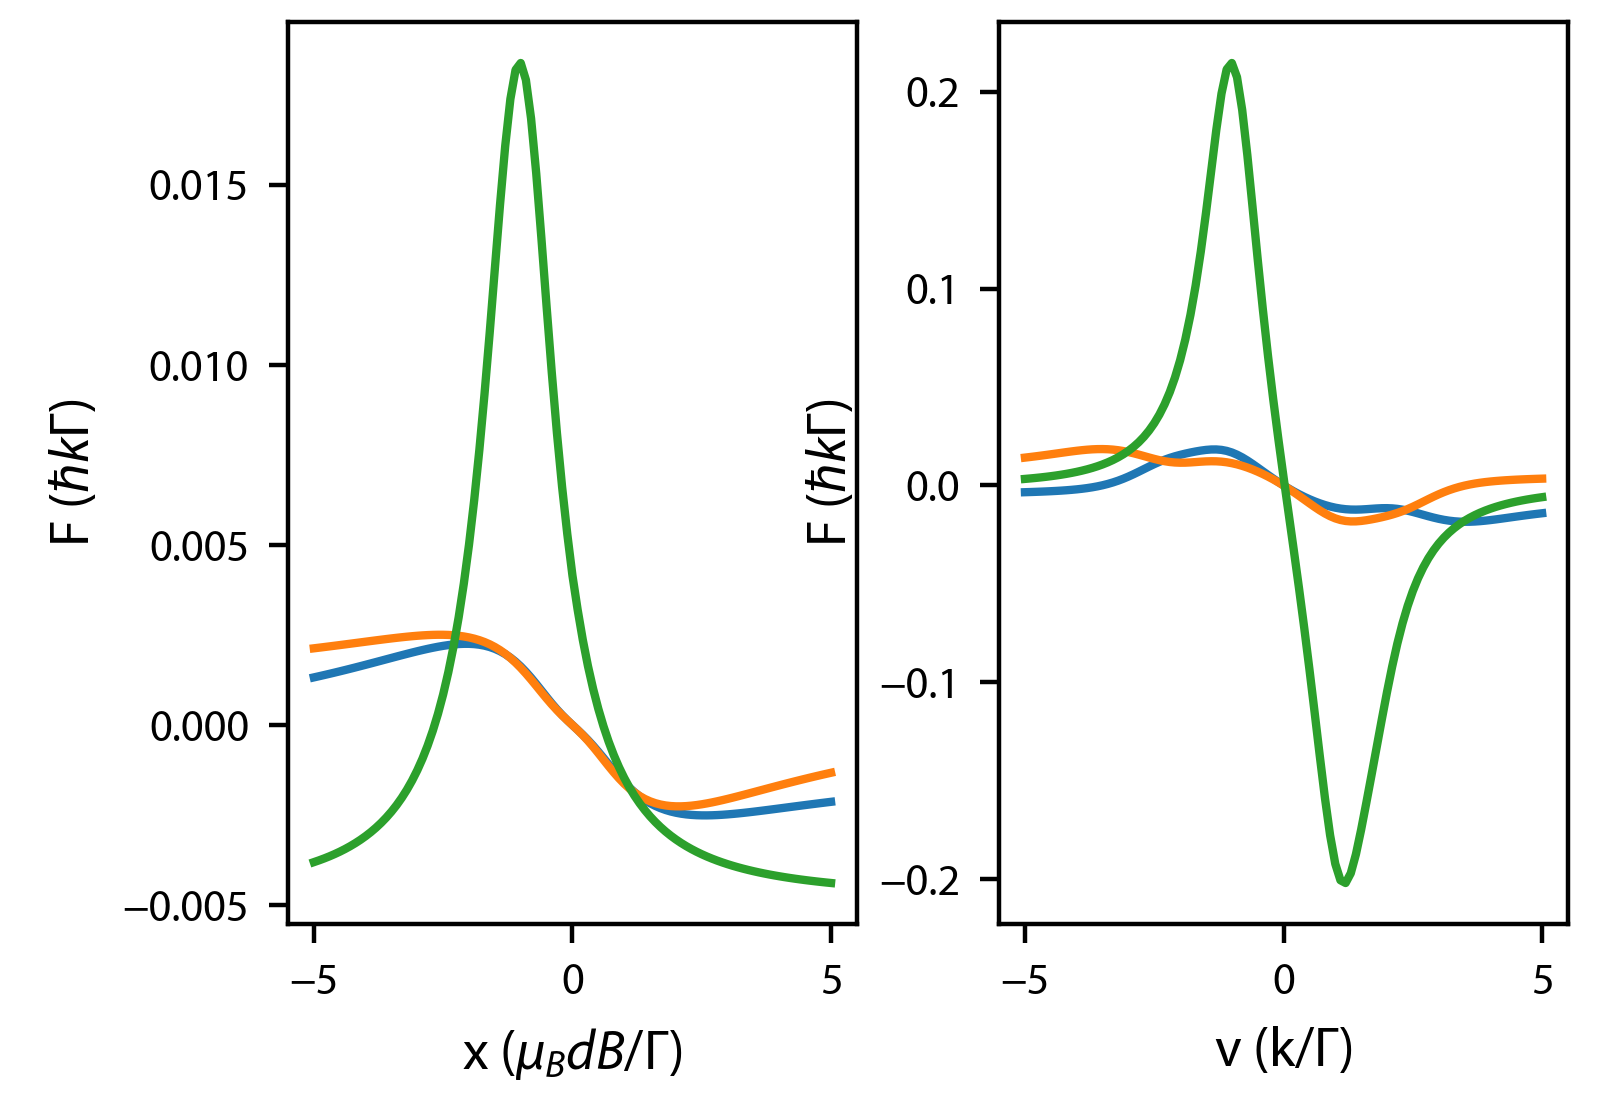

<IPython.core.display.Javascript object>


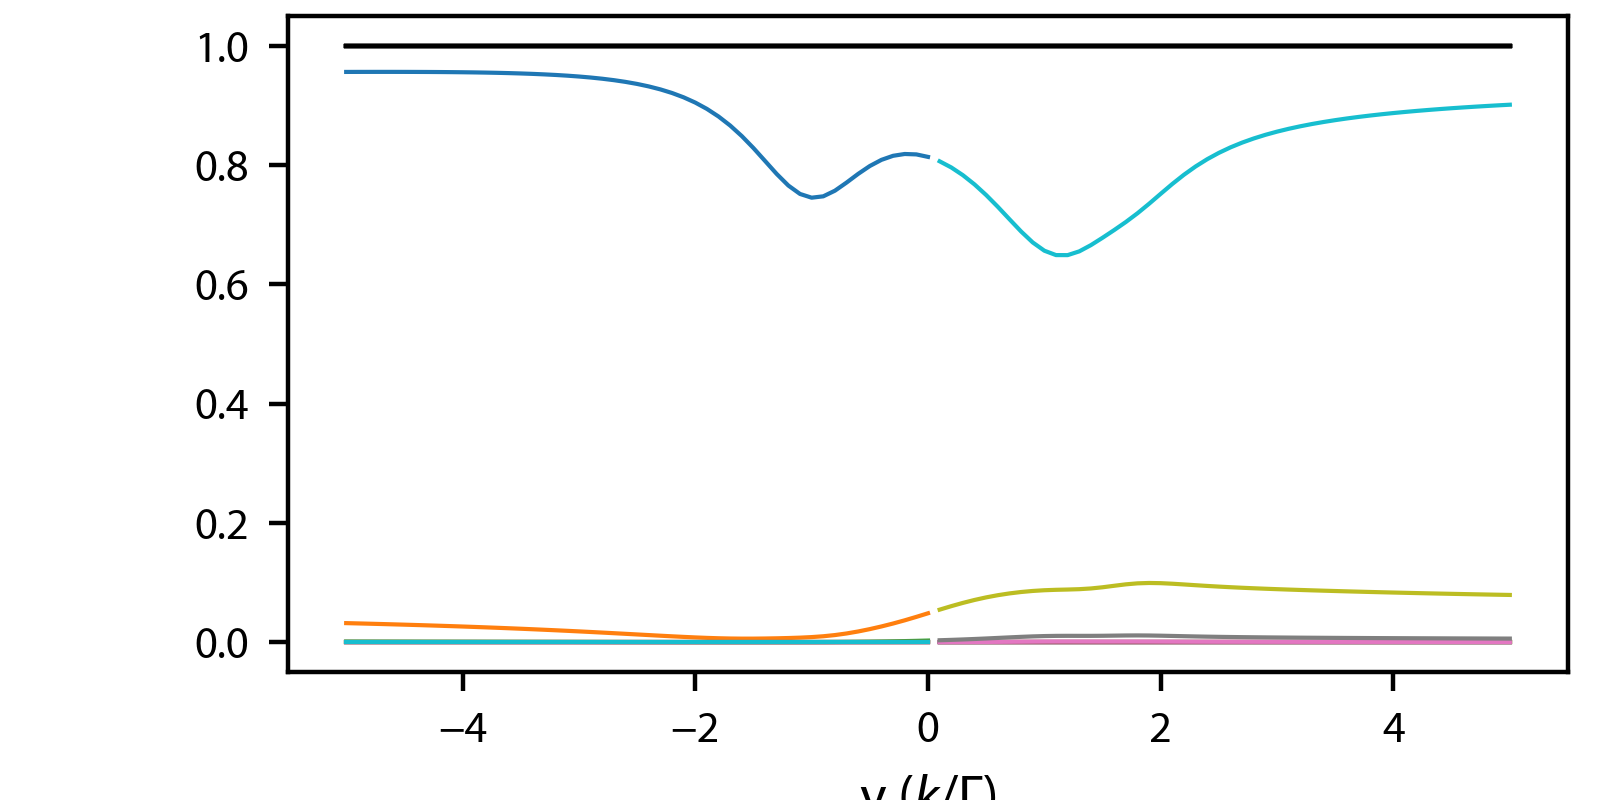

In [5]:
fig = plt.figure()
fig.set_size_inches((4,2.75))
gs = gridspec.GridSpec(1,2,wspace=0.25)

ax = [0,0]
ax[0] = fig.add_subplot(gs[0,0])
for ii, axis in enumerate(axis_list):
    ax[0].plot(z, trap_1d[axis].profile['F'+axis].F[ii])
    ax[0].set_xlabel('x ($\mu_B dB/\Gamma$)')
    ax[0].set_ylabel('F ($\hbar k \Gamma$)')
    
ax[1] = fig.add_subplot(gs[0,1])
for ii, axis in enumerate(axis_list):
    ax[1].plot(v, trap_1d[axis].profile['Fv_'+axis].F[ii])
    ax[1].set_xlabel('v (k/$\Gamma$)')
    ax[1].set_ylabel('F ($\hbar k \Gamma$)')
    #ax[1].set_ylim(-.05,.05)

fig = plt.figure()
fig.set_size_inches((4,2.0))
gs = gridspec.GridSpec(1,1)

jj = 2
axis = axis_list[jj]
ax = fig.add_subplot(gs[0,0])
for ii in range(10):
    inds = trap_1d[axis].profile['Fv_'+axis].V[jj] <= 0.
    ax.plot(trap_1d[axis].profile['Fv_'+axis].V[jj][inds],
            trap_1d[axis].profile['Fv_'+axis].Neq[inds, 9-ii], color='C%d'%ii,
            linewidth=0.75)
    ax.plot(trap_1d[axis].profile['Fv_'+axis].V[jj][np.bitwise_not(inds)],
            trap_1d[axis].profile['Fv_'+axis].Neq[np.bitwise_not(inds), ii],
            color='C%d'%ii, linewidth=0.75)
    ax.plot(trap_1d[axis].profile['Fv_'+axis].V[jj],
            np.sum(trap_1d[axis].profile['Fv_'+axis].Neq,axis=1),
            color='black', linewidth=0.75)
    ax.set_xlabel('v ($k/\Gamma$)')

<IPython.core.display.Javascript object>


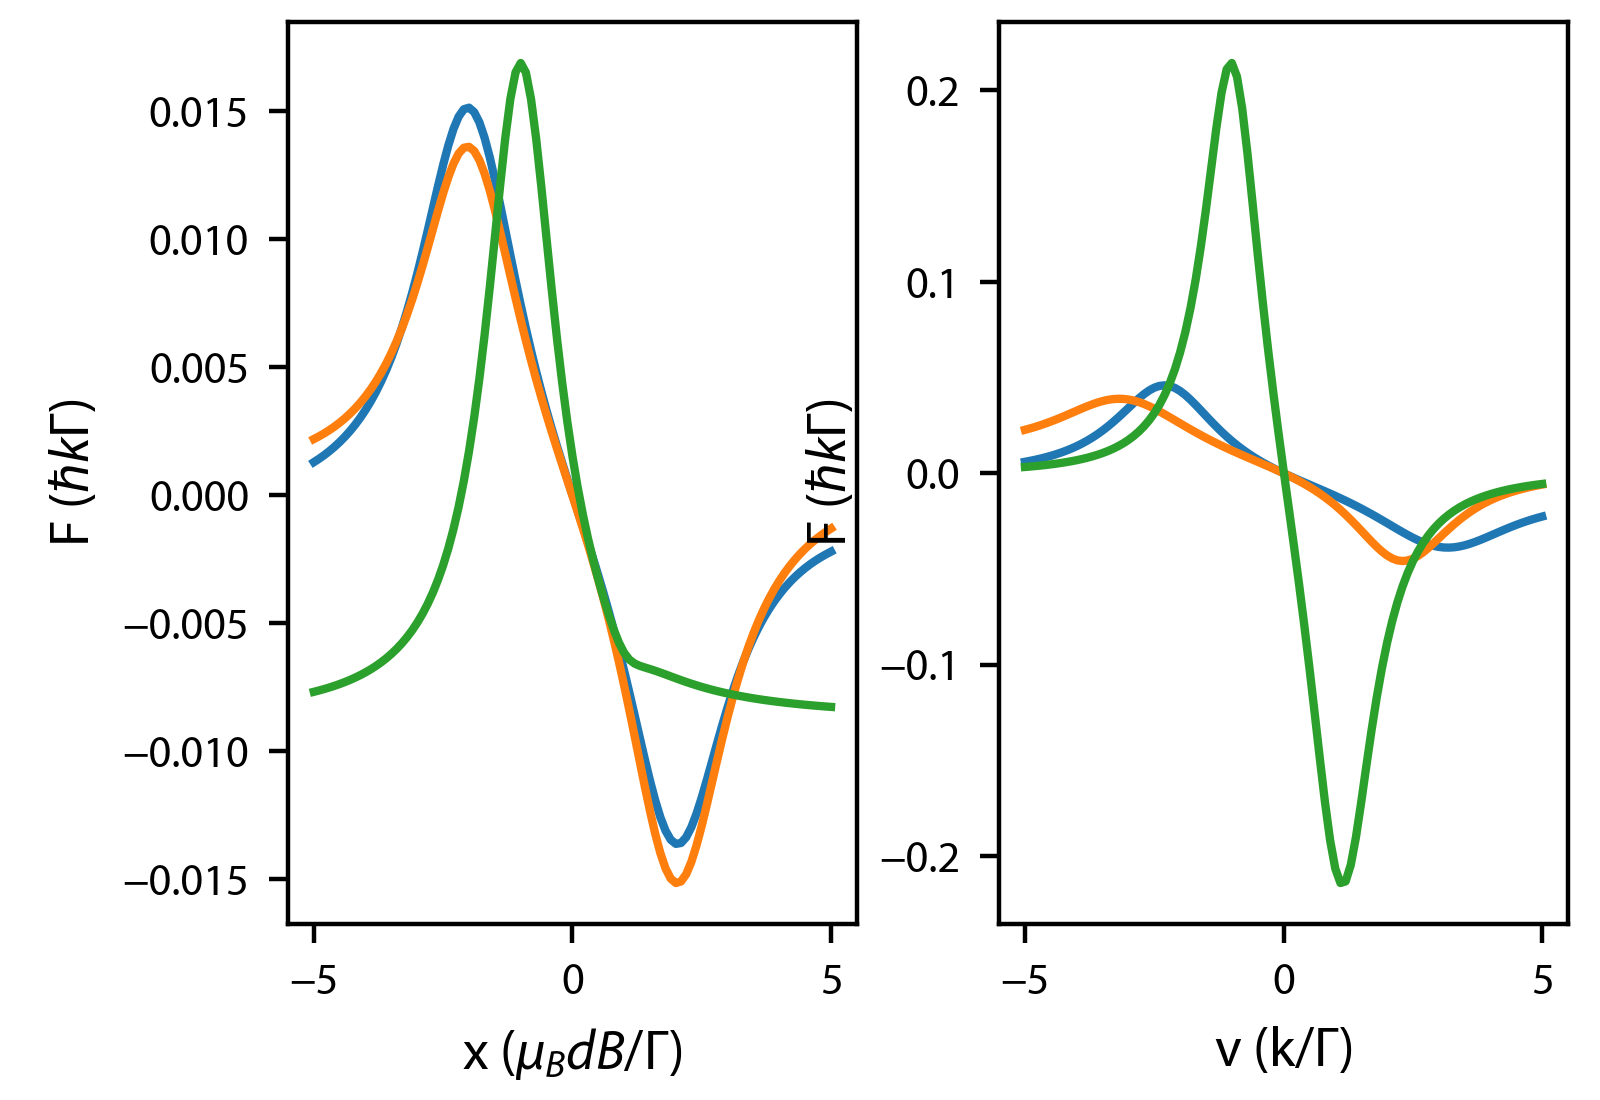

In [6]:
"""
Look at all spatial dimesions for Sr-88 in the grating MOT
"""
#laserBeams = grating_MOT_beams(det, beta, Nb, thd, eta=eta, grating_angle=g_angle)

# First, define the coordinate system:
z = np.arange(-5.0, 5.01, 0.1)
v = np.arange(-5.0, 5.01, 0.1)

pos_offset = 1e-16 # offset position in velocity calc for bug checking
trap_zpos = 0.129
axis_list = ['x', 'y', 'z']
trap_1d = {}
for axis in axis_list:
    if axis == 'x':
        # force at the origin:
        #pos_list = [z, 1.0*np.zeros(z.shape), 1.0*np.zeros(z.shape)]
        # force at the trap position:
        pos_list = [z, 1.0*np.zeros(z.shape), np.full(z.shape, trap_zpos)]
        vpos_list = [1.0*np.full(z.shape, pos_offset), 1.0*np.zeros(z.shape), 1.0*np.zeros(z.shape)]
    elif axis == 'y':
        # force at the origin:
        #pos_list = [1.0*np.zeros(z.shape), z, 1.0*np.zeros(z.shape)]
        # force at the trap position:
        pos_list = [1.0*np.zeros(z.shape), z, np.full(z.shape, trap_zpos)]
        vpos_list = [1.0*np.zeros(z.shape), 1.0*np.full(z.shape, pos_offset), 1.0*np.zeros(z.shape)]
    else:
        pos_list = [1.0*np.zeros(z.shape), 1.0*np.zeros(z.shape), z]
        vpos_list = [1.0*np.zeros(z.shape), 1.0*np.zeros(z.shape), 1.0*np.full(z.shape, pos_offset)]
    trap_1d[axis] = pylcp.trap_rateeq(laserBeams, magField, hamiltonian["$^{88}$Sr"])
    trap_1d[axis].generate_force_profile(
        pos_list,
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='F'+axis)
    trap_1d[axis].generate_force_profile(
        vpos_list,
        pos_list,
        name='Fv_'+axis)

fig = plt.figure()
fig.set_size_inches((4,2.75))
gs = gridspec.GridSpec(1,2,wspace=0.25)

ax = [0,0]
ax[0] = fig.add_subplot(gs[0,0])
for ii, axis in enumerate(axis_list):
    ax[0].plot(z, trap_1d[axis].profile['F'+axis].F[ii])
    ax[0].set_xlabel('x ($\mu_B dB/\Gamma$)')
    ax[0].set_ylabel('F ($\hbar k \Gamma$)')
    
ax[1] = fig.add_subplot(gs[0,1])
for ii, axis in enumerate(axis_list):
    ax[1].plot(v, trap_1d[axis].profile['Fv_'+axis].F[ii])
    ax[1].set_xlabel('v (k/$\Gamma$)')
    ax[1].set_ylabel('F ($\hbar k \Gamma$)')
    #ax[1].set_ylim(-.05,.05)

## Trap Depth Calculations

Okay, it looks like the fermion MOT behaves more like we expect when I expand the force about the trap center (rather than at the origin). To see if we should make a trap, we need to see if a distribution with our MOT temperature has a reasonable number of closed trajectories.

In [11]:
# Define rms velocity:
def v_rms(T, species):
    return np.sqrt(cts.value('Boltzmann constant')*T/m[species])*kvec[species]/gamma[species]
# What is rms velocity of the transverse direction of the MOT in our units:
print(2*v_rms(3.5e-3, "$^{87}$Sr")) # 95 % of atoms inside this velocity/energy
print(2*v_rms(3.5e-3, "$^{88}$Sr")) # 95 % of atoms inside this velocity/energy

0.08229452258530014
0.08182560410966307


The trap depth is only about 0.2 (in scaled velocity units), so we're in the small depth regime... Not so clear to me what is going to happen given weaker damping of the fermion. Will 87 be colder or hotter? What is the ratio of the escape velocity to v_rms?

In [12]:
# calculate approximate ratio of escape velocity to v_rms for 87Sr:
print(0.3/v_rms(3.5e-3, "$^{87}$Sr"))
# and 88Sr:
print(0.8/v_rms(3.5e-3, "$^{88}$Sr"))

7.290886211510449
19.553781697177236


v_escape/v_rms approximately 7 puts us in the intermediate depth limit for 87Sr. We're in the deep trap limit for 88Sr

In [14]:
s_calc = "$^{88}$Sr"
# approximate trap depth in mK for 88Sr:
print(10**3*m[s_calc]*(0.15*gamma[s_calc]/kvec[s_calc])**2/cts.value('Boltzmann constant'))
# and 88Sr:
print(10**3*m[s_calc]*(2.5*gamma[s_calc]/kvec[s_calc])**2/cts.value('Boltzmann constant'))

47.04701924928594
13068.616458134982


## 3D Simulations

### Conventional MOT

In [85]:
"""
Now, let's consider the full phase space for each spatial direction in a conventional 3D MOT:
"""
trap3D = {}

# First, define the coordinate system:
z = np.linspace(-5.0, 5.0, 150)
v = np.linspace(-5.0, 5.0, 150)
Z, V = np.meshgrid(z, v)
#V, Z = np.meshgrid(z, v)
trap_zpos = 0.0
for species in species_list:
    wbin = beamRad*(grad[2]*muB)/gammaHz[species]
    rstop = 1.1*(grad[2]*muB)/gammaHz[species]
    Beams3D = conventional3DMOTBeams(delta=det, beta=(beta+3*eta*beta/np.cos(thd))/6, 
                                     beam_type=clippedGaussianBeam, wb=wbin, rs=rstop)
    for ii, axis in enumerate(axis_list):
        if axis == 'x':
            # expand about origin
            #pos_list = [Z, np.zeros(Z.shape), np.zeros(Z.shape)]
            # expand about trap location
            pos_list = [Z, np.zeros(Z.shape), np.full(Z.shape, trap_zpos)]
            v_list = [V, np.zeros(Z.shape), np.zeros(Z.shape)]
        elif axis == 'y':
            # expand about origin
            #pos_list = [np.zeros(Z.shape), Z, np.zeros(Z.shape)]
            # expand about trap location
            pos_list = [np.zeros(Z.shape), Z, np.full(Z.shape, trap_zpos)]
            v_list = [np.zeros(Z.shape), V, np.zeros(Z.shape)]
        else:
            pos_list = [np.zeros(Z.shape), np.zeros(Z.shape), Z]
            v_list = [np.zeros(Z.shape), np.zeros(Z.shape), V]
        trap3D[(species, axis)] = pylcp.trap_rateeq(Beams3D, mag_field, hamiltonian[species],
                                                    include_mag_forces=False)
        trap3D[(species, axis)].generate_force_profile(pos_list, v_list, name='F_v,'+axis)

/Users/daniel/Documents/GitHub/packages/pylcp/rateeq.py:215: ComplexWarning: Casting complex values to real discards the imaginary part
  np.dot(kvec, v))**2)


In [86]:
# interpolate x, v force profile:
f3D = {}
interp_img_3D = {}
for species in species_list:
    for ii, axis in enumerate(axis_list):
        trap3D[(species, axis)].profile['F_v,'+axis].F[ii] = np.nan_to_num(trap3D[(species, axis)].profile['F_v,'+axis].F[ii])
        print(np.any(np.isnan(trap3D[(species, axis)].profile['F_v,'+axis].F[ii])))
#         f3D[(species, axis)] = interp2d(V, Z, \
#                                         trap3D[(species, axis)].profile['F_v,'+axis].F[ii],
#                                         kind='linear', fill_value=0)
        f3D[(species, axis)] = RectBivariateSpline(v, z,
                                                   trap3D[(species, axis)].profile['F_v,'+axis].F[ii],
                                                   kx=3, ky=3)
        interp_img_3D[(species, axis)] = f3D[(species, axis)](v, z)#.transpose()
        print(np.sum(np.abs(interp_img_3D[(species, axis)]-trap3D[(species,axis)].profile['F_v,'+axis].F[ii])))

False
1.05204175449361e-13
False
1.0588692466242944e-13
False
9.428464640308326e-14
False
1.0162720274695114e-13
False
1.0080445592836051e-13
False
9.354176504564049e-14
False
1.0624685267864031e-13
False
1.075942991386053e-13
False
9.484216515664047e-14
False
8.210855498118341e-14
False
8.219111697661818e-14
False
6.008873411865456e-14


In [105]:
# use odeint to solve odes

# iterate over initial conditions and axes:
sols3D = {}
#t = np.linspace(0,25e-3,501) # for SI units
t = np.linspace(0,5e6,501) # for scaled units
span = [t[0],t[-1]]
solver='DOP853'
for species in species_list:
    # grid of initial values for x and y:
    x = 0
#     vx = (gamma[species]/kvec[species])*np.linspace(-1.0, 1.0, 21) # for SI units
    vx = np.linspace(-1.0, 1.0, 21) # for scaled units
    X, VX = np.meshgrid(x, vx)
    y0 = np.column_stack((VX.reshape(-1), X.reshape(-1)))
    # grid of initial values for z:
#     x = 4.99*(gammaHz[species]/(grad[2]*100*muB)) # for SI units
#     vx = (gamma[species]/kvec[species])*np.linspace(-4.9, -1.5, 12) # for SI units
    x = 4.99 # for scaled units
    vx = np.linspace(-4.9, -1.5, 12) # for scaled units
    X, VX = np.meshgrid(x, vx)
    z0 = np.column_stack((VX.reshape(-1), X.reshape(-1)))
    for ii, axis in enumerate(axis_list):
        if axis == 'z':
            sols3D[(species,axis)] = np.zeros((z0.shape[0], 2, t.shape[0]))
            for jj, z0_i in enumerate(z0):
                st = solve_ivp(lambda t, y: motion_des2(t, y, species, f3D[(species, axis)]), \
                               span, [z0_i[0],z0_i[1]/x_scale[species]], method=solver, t_eval=t, \
                               vectorized=True, rtol=1e-9, atol=1e-12)
#                 st = solve_ivp(lambda t, y: motion_des(t, y, species, f3D[(species, axis)]), \
#                                span, y0_i, method='RK45', t_eval=t, vectorized=True)
                sols3D[(species, axis)][jj] = st.y
        else:
            sols3D[(species,axis)] = np.zeros((y0.shape[0], 2, t.shape[0]))
            for jj, y0_i in enumerate(y0):
                st = solve_ivp(lambda t, y: motion_des2(t, y, species, f3D[(species, axis)]), \
                               span, y0_i, method=solver, t_eval=t, vectorized=True, \
                               rtol=1e-9, atol=1e-12)
#                 st = solve_ivp(lambda t, y: motion_des(t, y, species, f3D[(species, axis)]), \
#                                span, y0_i, method='RK45', t_eval=t, vectorized=True)
                sols3D[(species,axis)][jj] = st.y

<IPython.core.display.Javascript object>


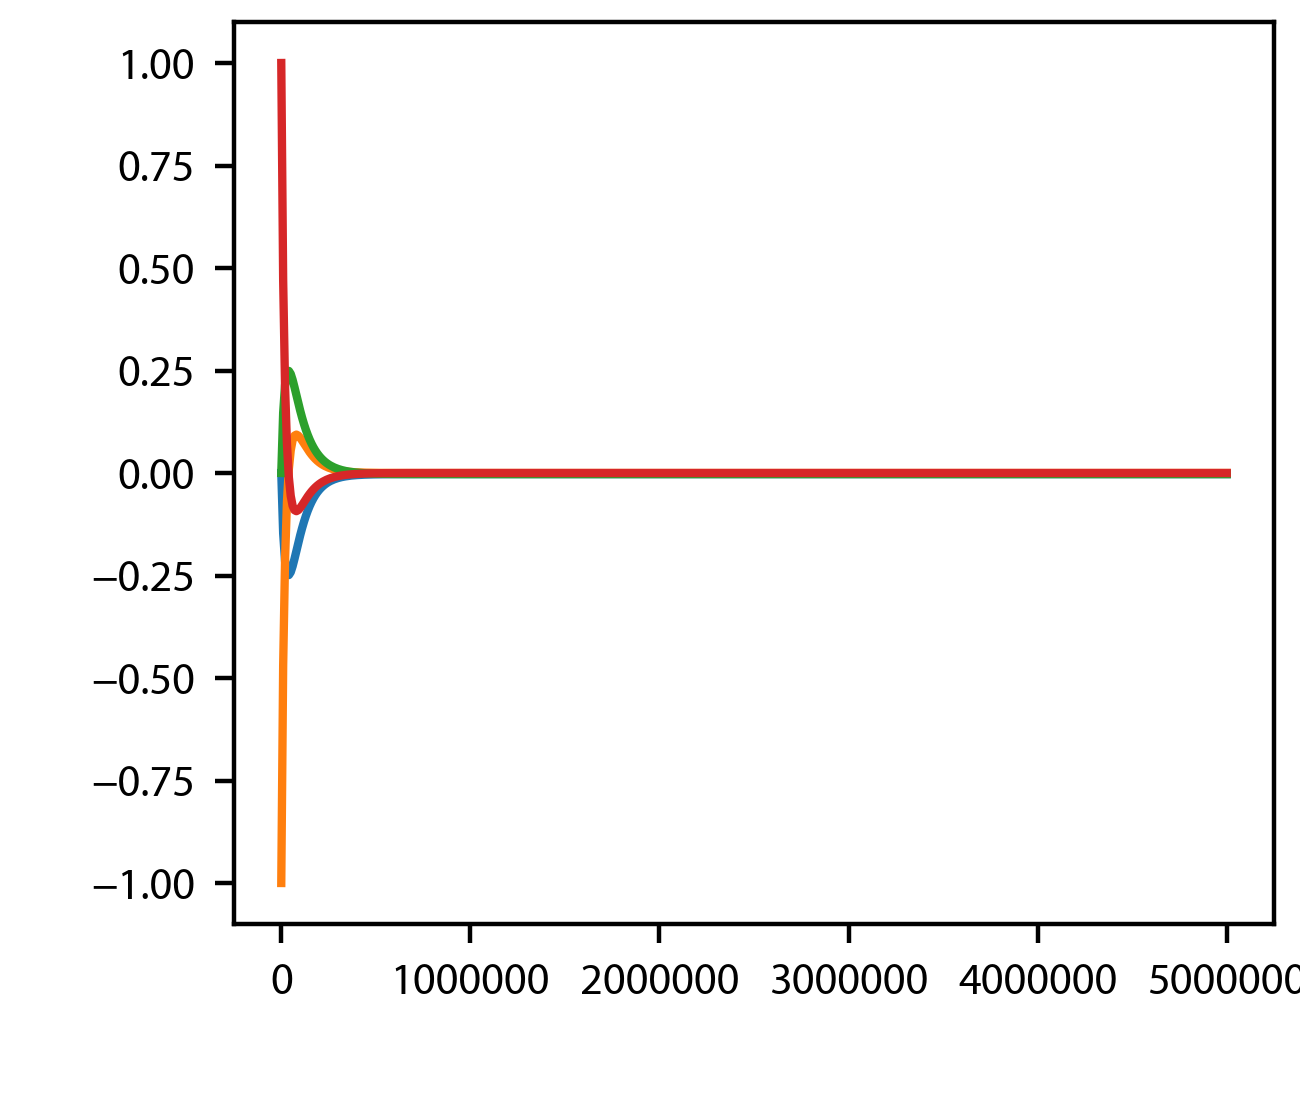

In [43]:
# Figure out where the z trajectories damp to, so that I can redo the force profiles in that
# plane.
s_toplot = "$^{88}$Sr"
plt.figure()
ii = 0
axis = axis_list[ii]
plt.plot(t,x_scale[s_toplot]*sols3D[(s_toplot,axis)][0,1,:])
plt.plot(t,sols3D[(s_toplot,axis)][0,0,:])
plt.plot(t,x_scale[s_toplot]*sols3D[(s_toplot,axis)][-1,1,:])
plt.plot(t,sols3D[(s_toplot,axis)][-1,0,:])
#plt.ylim(-0.2,2.0)
# print((grad[ii]*100*muB/gammaHz)*sols87[axis][0,-1,1])
# print((grad[ii]*100*muB/gammaHz)*sols87[axis][-1,-1,1])
#print(np.average(x_scale[s_toplot]*solsGMOT[(s_toplot,axis)][:,1,-1]))
#print(np.std(x_scale[s_toplot]*solsGMOT[(s_toplot,axis)][:,1,-1]))
# for ii in np.arange(11):
#     print(V[45+ii,0])

<IPython.core.display.Javascript object>


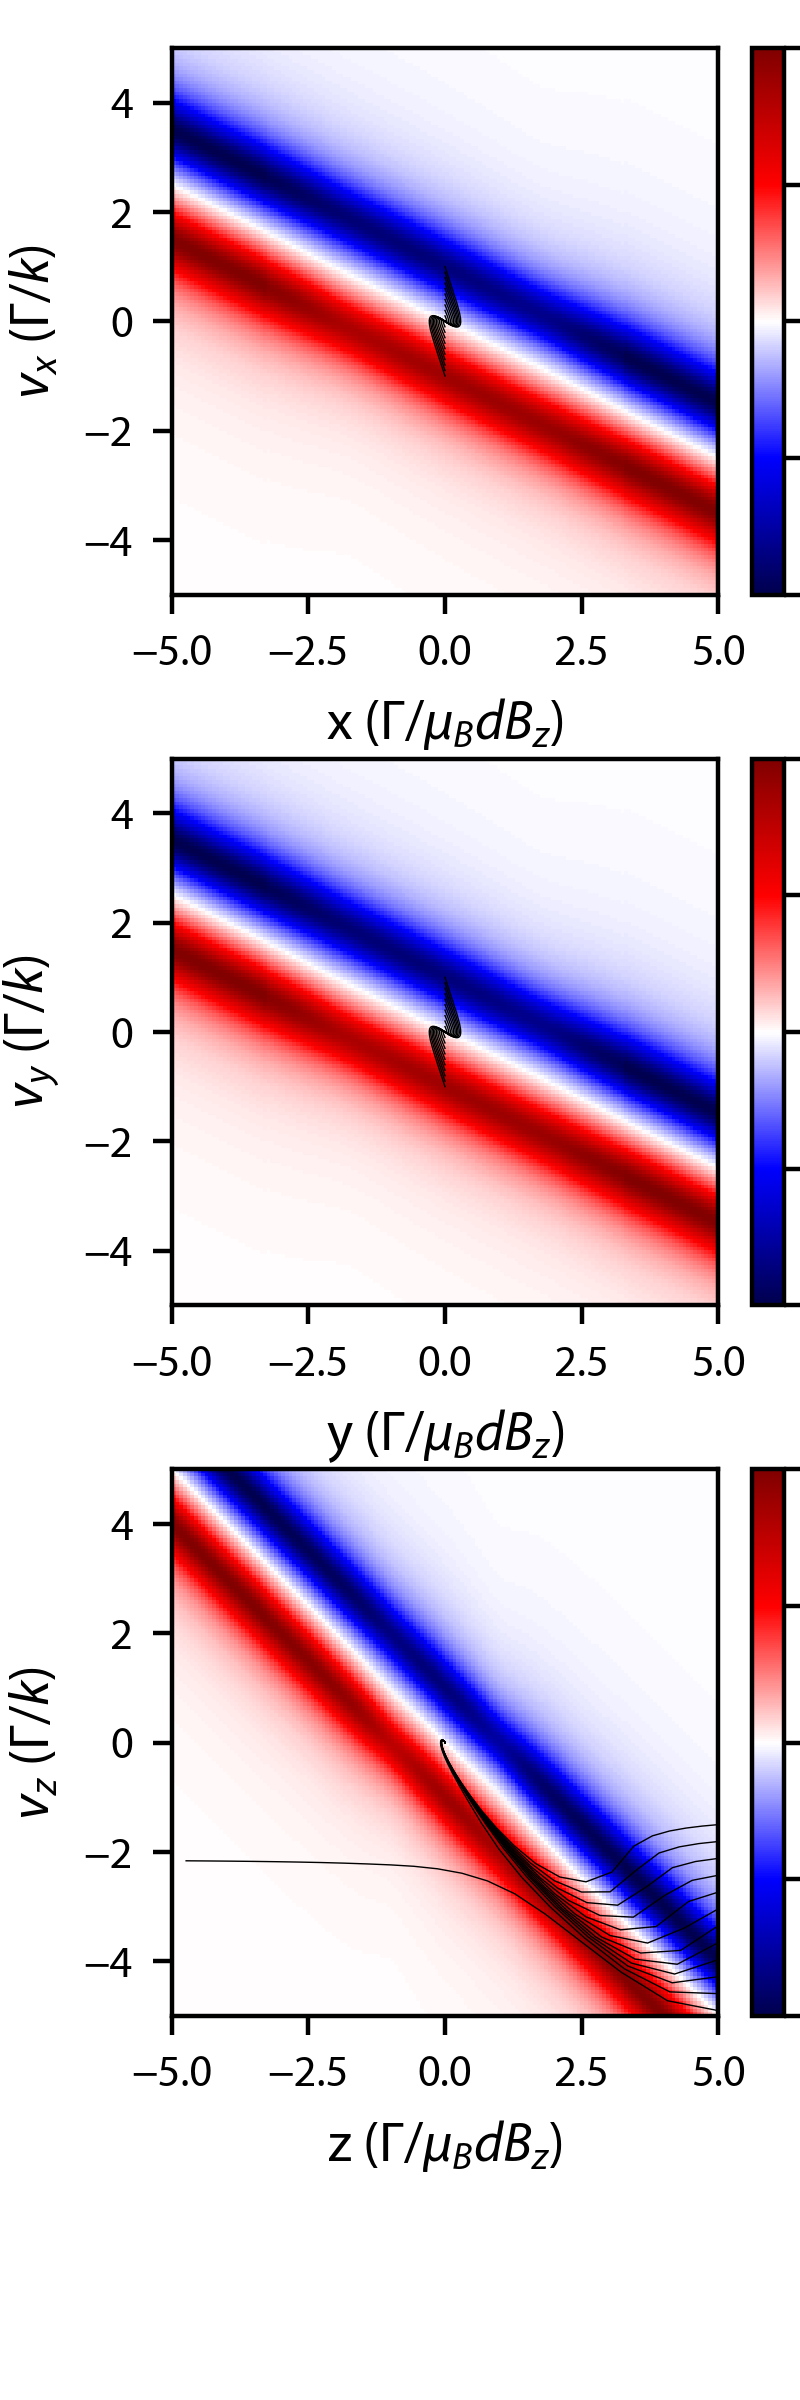

In [106]:
fig = plt.figure()
fig.set_size_inches((2.0,6))
gs = gridspec.GridSpec(3,2,hspace=0.3,wspace=0.02, width_ratios=(19,1))

#v = np.arange(-5.0, 5.01, 0.05)

s_toplot = "$^{174}$Yb"
ax=[0,0,0]
cax=[0,0,0]
for ii, axis in enumerate(axis_list):
    ax[ii] = fig.add_subplot(gs[ii,0])
    cax[ii] = fig.add_subplot(gs[ii,1])
    fmax=np.amax(np.abs(trap3D[(s_toplot,axis)].profile['F_v,'+axis].F[ii]))
    cax_lim = np.round(fmax, decimals = 2)
    im = ax[ii].imshow(trap3D[(s_toplot,axis)].profile['F_v,'+axis].F[ii], \
                       norm=colors.DivergingNorm(vcenter=0,vmin=-cax_lim,vmax=cax_lim), \
                       origin='lower', extent=[np.round(np.min(v)),np.round(np.max(v)), \
                                               np.round(np.min(v)),np.round(np.max(v))], \
                       interpolation='none', cmap='seismic')
#     im = ax[ii].imshow(interp_img_3D[(s_toplot,axis)], \
#                        norm=colors.DivergingNorm(vcenter=0,vmin=-cax_lim,vmax=cax_lim), \
#                        origin='lower', extent=[np.round(np.min(v)),np.round(np.max(v)), \
#                                                np.round(np.min(v)),np.round(np.max(v))], \
#                        interpolation='none', cmap='seismic')
    for sol in sols3D[(s_toplot,axis)]:
        ind = np.argwhere((np.abs(x_scale[s_toplot]*sol[1,:])<5.0) &
                          (np.abs(sol[0,:])<5.0))
        ax[ii].plot(x_scale[s_toplot]*sol[1,ind],
                    sol[0,ind],
                    linestyle='-', linewidth=0.25, color='black')
    cbar = plt.colorbar(im, cax=cax[ii])
    cbar.set_label('F ($\hbar k \Gamma$)')
    cbar.set_ticks([-cax_lim, -cax_lim/2, 0, cax_lim/2, cax_lim])
    #cax[ii].xaxis.set_label_coords(cax_lim,-cax_lim)
#     ax[ii].axvline(x=-beamRad*(grad[2]*muB)/gammaHz[s_toplot], linestyle = '--', \
#                    linewidth = 0.75, color = 'black')
#     ax[ii].axvline(x=beamRad*(grad[2]*muB)/gammaHz[s_toplot], linestyle = '--', \
#                    linewidth = 0.75, color = 'black')
#     if axis == 'x' or axis == 'y':
#         ax[ii].add_patch(matplotlib.patches.Circle((0,0), 1.75, linestyle = '--', \
#                                                    linewidth = 0.75, color = 'red', \
#                                                    fill = False))
    ax[ii].set_xlabel(axis+' ($\Gamma/\mu_B dB_z$)', fontsize=10)
    ax[ii].set_ylabel('$v_'+axis+'$ ($\Gamma/k$)', fontsize=10)

if s_toplot == "$^{88}$Sr":
    plt.savefig('Sr88_3DMOT_mag.png', format='png', dpi=200, bbox_inches='tight')
elif s_toplot == "$^{87}$Sr":
    plt.savefig('Sr87_3DMOT_mag.png', format='png', dpi=200, bbox_inches='tight')
elif s_toplot == "$^{171}$Yb":
    plt.savefig('Yb171_3DMOT_mag.png', format='png', dpi=200, bbox_inches='tight')

### Grating MOT

2.703816414347088
3.4153470497015848
3.1307347955597864
0.4269183812126981


<IPython.core.display.Javascript object>


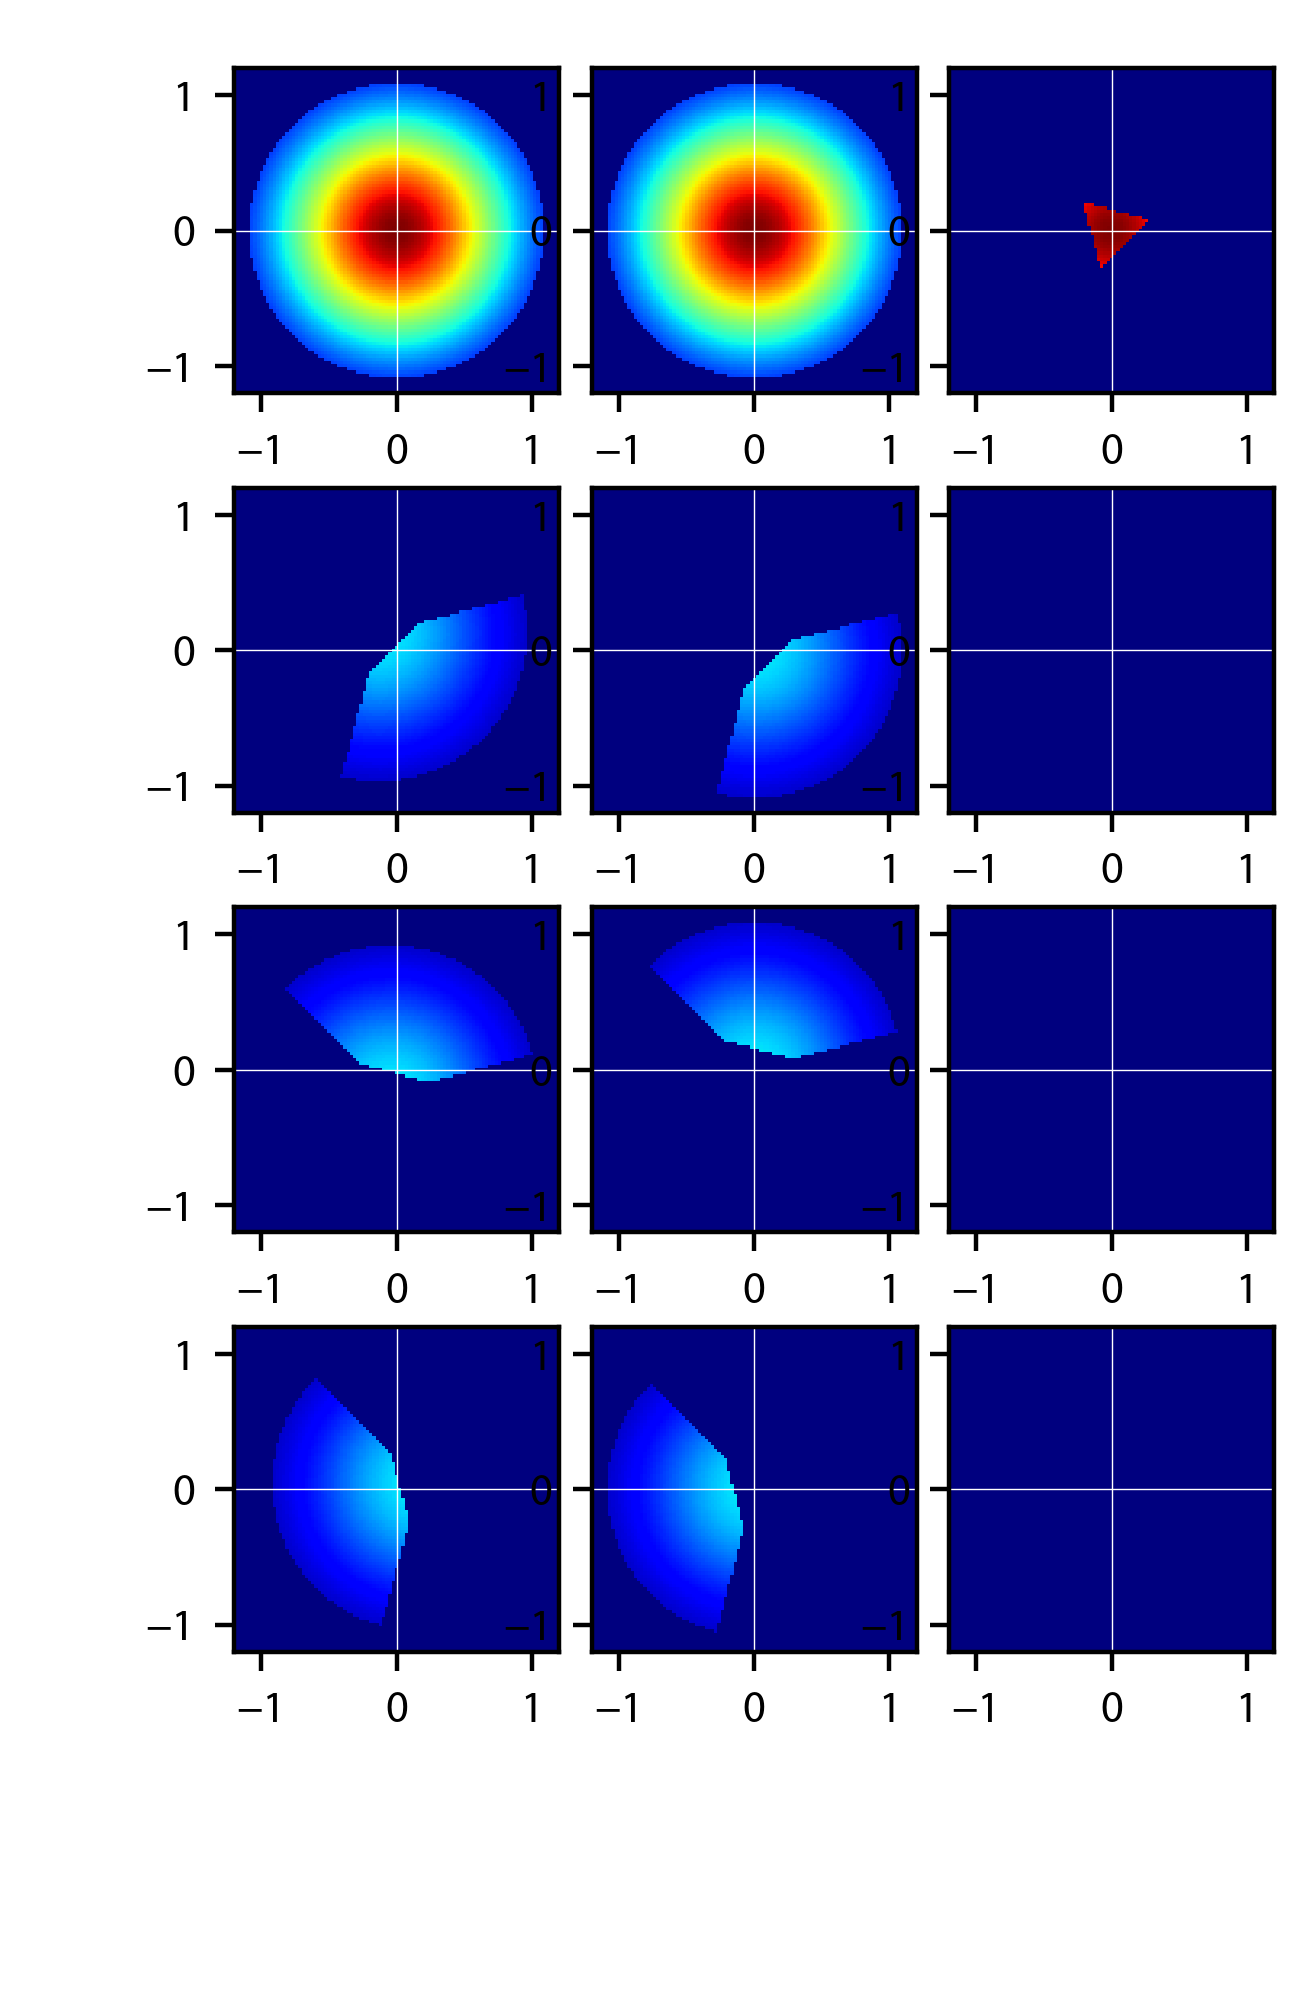

In [11]:
# Check that the beams in the new grating MOT function work:
# Initial spacing of magnets: 2.1*25.4 mm
# Installed spacing of magnets: 60 mm
# Designed distance of the chip from the field zero is 6.125 mm
# Therefore:
zchip = np.round(0.6125+(6-2.1*2.54)/2,2)*(grad[2]*muB)/gammaHz['$^{88}$Sr']
wbin = beamRad*(grad[2]*muB)/gammaHz['$^{88}$Sr']
rstop = 1.1*(grad[2]*muB)/gammaHz['$^{88}$Sr']
aperture = 0.15*(grad[2]*muB)/gammaHz['$^{88}$Sr']
print(zchip)
print(wbin)
print(rstop)
print(aperture)
testBeams = maskedGaussianGratingMOTBeams(delta=det, s=beta, nr=Nb, thd=thd, eta=eta, eta0=None, wb=wbin, rs=rstop, \
                                          center_hole=aperture, outer_radius=rstop, zgrating=zchip, \
                                          grating_angle=g_angle)
x_beta = 1.2*(grad[2]*muB)/gammaHz['$^{88}$Sr']
X, Y = np.meshgrid(np.linspace(-x_beta, x_beta, 101),
                   np.linspace(-x_beta, x_beta, 101))
z_tests = [zchip-1, zchip-1e-9, zchip+1]

plt.figure("Laser Beams", figsize=(3.25, 5))
plt.clf()
for jj, laserBeam in enumerate(testBeams.beam_vector):
    for ii, z_test in enumerate(z_tests):
        plt.subplot(len(testBeams.beam_vector), len(z_tests), jj*len(z_tests)+ii+1)
        Rt=np.array([X, Y, z_test*np.ones(X.shape)])
        tt=np.zeros(X.shape)
        plt.imshow(laserBeam.beta(R=Rt,t=tt),
                   origin='lower',
                   extent=(-x_beta*gammaHz['$^{88}$Sr']/(grad[2]*muB), x_beta*gammaHz['$^{88}$Sr']/(grad[2]*muB),
                           -x_beta*gammaHz['$^{88}$Sr']/(grad[2]*muB), x_beta*gammaHz['$^{88}$Sr']/(grad[2]*muB)))
        plt.clim((0, beta))
        plt.set_cmap('jet')
        # Make a cross-hair:
        plt.plot([0, 0], [-x_beta*gammaHz['$^{88}$Sr']/(grad[2]*muB), x_beta*gammaHz['$^{88}$Sr']/(grad[2]*muB)],
                 'w-', linewidth=0.25)
        plt.plot([-x_beta*gammaHz['$^{88}$Sr']/(grad[2]*muB), x_beta*gammaHz['$^{88}$Sr']/(grad[2]*muB)], [0, 0],
                 'w-', linewidth=0.25)

In [95]:
"""
Now, let's consider the full phase space for each spatial direction in a gMOT:
"""
trapGMOT = {}

# Simple plane wave beams:
#BeamsGMOT = grating_MOT_beams(det, beta, Nb, thd, eta=eta, grating_angle=g_angle)
# For fancy beams, need to put GMOT definition inside the loop.

# First, define the coordinate system:
z = np.linspace(-5.0, 5.0, 150)
v = np.linspace(-5.0, 5.0, 150)
Z, V = np.meshgrid(z, v)
#V, Z = np.meshgrid(z, v)
#trap_zpos = {"$^{88}$Sr":0.129, "$^{87}$Sr":0.593,"$^{171}$Yb":0.787} # for plane wave beams
#trap_zpos = {"$^{88}$Sr":0.640, "$^{87}$Sr":1.091,"$^{171}$Yb":1.433} # for clipped beams and beamRad=1.5,
                                                                      # with eta0=None
#trap_zpos = {"$^{88}$Sr":0.538, "$^{87}$Sr":0.050, "$^{174}$Yb":0.538, "$^{171}$Yb":1.097} # BeamRad = 1.8
trap_zpos = {"$^{88}$Sr":0.780, "$^{87}$Sr":0.342, "$^{174}$Yb":0.794, "$^{171}$Yb":1.359} # BeamRad = 1.2
#trap_zpos = {"$^{88}$Sr":0., "$^{87}$Sr":0.,"$^{171}$Yb":0.} # expand about the origin
for species in species_list:
    # Use fancy clipped gaussian beams:
    zchip = 0.95*(grad[2]*muB)/gammaHz[species]
    wbin = beamRad*(grad[2]*muB)/gammaHz[species]
    rstop = 1.1*(grad[2]*muB)/gammaHz[species]
    aperture = 0.15*(grad[2]*muB)/gammaHz[species]
    BeamsGMOT = maskedGaussianGratingMOTBeams(delta=det, s=beta, nr=Nb, thd=thd, eta=eta, eta0=None, \
                                              wb=wbin, rs=rstop, center_hole=aperture, outer_radius=rstop, \
                                              zgrating=zchip, grating_angle=g_angle)
    for ii, axis in enumerate(axis_list):
        if axis == 'x':
            # expand about origin
            #pos_list = [Z, np.zeros(Z.shape), np.zeros(Z.shape)]
            # expand about trap location
            pos_list = [Z, np.zeros(Z.shape), np.full(Z.shape, trap_zpos[species])]
            v_list = [V, np.zeros(Z.shape), np.zeros(Z.shape)]
        elif axis == 'y':
            # expand about origin
            #pos_list = [np.zeros(Z.shape), Z, np.zeros(Z.shape)]
            # expand about trap location
            pos_list = [np.zeros(Z.shape), Z, np.full(Z.shape, trap_zpos[species])]
            v_list = [np.zeros(Z.shape), V, np.zeros(Z.shape)]
        else:
            pos_list = [np.zeros(Z.shape), np.zeros(Z.shape), Z]
            v_list = [np.zeros(Z.shape), np.zeros(Z.shape), V]
        trapGMOT[(species, axis)] = pylcp.trap_rateeq(BeamsGMOT, mag_field, hamiltonian[species],
                                                      include_mag_forces=False)
        trapGMOT[(species, axis)].generate_force_profile(pos_list, v_list, name='F_v,'+axis)

/Users/daniel/Documents/GitHub/packages/pylcp/rateeq.py:215: ComplexWarning: Casting complex values to real discards the imaginary part
  np.dot(kvec, v))**2)


In [96]:
# interpolate x, v force profile:
fGMOT = {}
interp_img_GMOT = {}
for species in species_list:
    for ii, axis in enumerate(axis_list):
        trapGMOT[(species, axis)].profile['F_v,'+axis].F[ii] = np.nan_to_num(trapGMOT[(species, axis)].profile['F_v,'+axis].F[ii])
        print(np.any(np.isnan(trapGMOT[(species, axis)].profile['F_v,'+axis].F[ii])))
#         fGMOT[(species, axis)] = interp2d(V, Z,
#                                           trapGMOT[(species, axis)].profile['F_v,'+axis].F[ii],
#                                           kind='linear', fill_value=0)
        fGMOT[(species, axis)] = RectBivariateSpline(v, z,
                                                     trapGMOT[(species, axis)].profile['F_v,'+axis].F[ii],
                                                     kx=3, ky=3)
        interp_img_GMOT[(species, axis)] = fGMOT[(species, axis)](v, z)#.transpose()
        print(np.sum(np.abs(interp_img_GMOT[(species, axis)]-trapGMOT[(species,axis)].profile['F_v,'+axis].F[ii])))

False
1.6377318930801082e-14
False
1.624055135977305e-14
False
1.7845926169793693e-13
False
1.8175562390630808e-14
False
1.7858128326742074e-14
False
1.7840374800560683e-13
False
1.6484248195254044e-14
False
1.7073195642371927e-14
False
1.8104731750519677e-13
False
9.47122227381745e-15
False
9.233740427126122e-15
False
1.7710252074544172e-13


In [97]:
# use solve_ivp to integrate motion

# iterate over initial conditions and axes:
solsGMOT = {}
solsGMOT_em = {}
#t = np.linspace(0,25e-3,501) # for SI units
t = np.linspace(0,5e6,501) # for scaled units
span = [t[0],t[-1]]
solver='DOP853'
for species in species_list:
    # grid of initial values for x and y:
    x = 0
    #vx = (gamma[species]/kvec[species])*np.linspace(-1.0, 1.0, 21) # for SI units
    vx = np.linspace(-1.0, 1.0, 21) # for scaled units
    X, VX = np.meshgrid(x, vx)
    y0 = np.column_stack((VX.reshape(-1), X.reshape(-1)))
    # grid of initial values for z:
    #x = 4.99*(gammaHz[species]/(grad[2]*100*muB)) # for SI units
    #vx = (gamma[species]/kvec[species])*np.linspace(-4.9, -1.5, 12) # for SI units
    x = 4.99 # for scaled units
    vx = np.linspace(-4.2, -1.6, 11) # for scaled units
    X, VX = np.meshgrid(x, vx)
    z0 = np.column_stack((VX.reshape(-1), X.reshape(-1)))
    for ii, axis in enumerate(axis_list):
        if axis == 'z':
            solsGMOT[(species,axis)] = np.zeros((z0.shape[0], 2, t.shape[0]))
            solsGMOT_em[(species,axis)] = np.zeros((z0.shape[0], 2, t.shape[0]))
            for jj, z0_i in enumerate(z0):
                st = solve_ivp(lambda t, y: motion_des2(t, y, species, fGMOT[(species, axis)]), \
                               span, [z0_i[0],z0_i[1]/x_scale[species]], method=solver, t_eval=t, \
                               vectorized=True, rtol=1e-9, atol=1e-12)
                solsGMOT[(species, axis)][jj] = st.y
#                 trapGMOT[(species, axis)].set_initial_position_and_velocity(np.array([0,0,z0_i[1]]), \
#                                                                             np.array([0,0,z0_i[0]]))
#                 trapGMOT[(species, axis)].set_initial_pop_from_equilibrium()
#                 trapGMOT[(species, axis)].evolve_motion(span, mass_ratio=de_scale[species], \
#                                                         length_scale=x_scale[species], \
#                                                         freeze_axis=[True,True,False], \
#                                                         method='RK45', t_eval=t, vectorized=False, \
#                                                         rtol=1e-9, atol=1e-12)
#                 vt = trapGMOT[(species, axis)].sol.y[-6:-3]
#                 rt = trapGMOT[(species, axis)].sol.y[-3:]
#                 solsGMOT_em[(species, axis)][jj] = np.array([vt[ii],rt[ii]])
        elif axis == 'x':
            solsGMOT[(species,axis)] = np.zeros((y0.shape[0], 2, t.shape[0]))
            solsGMOT_em[(species,axis)] = np.zeros((y0.shape[0], 2, t.shape[0]))
            for jj, y0_i in enumerate(y0):
                st = solve_ivp(lambda t, y: motion_des2(t, y, species, fGMOT[(species, axis)]), \
                               span, y0_i, method=solver, t_eval=t, vectorized=True, \
                               rtol=1e-9, atol=1e-12)
                solsGMOT[(species,axis)][jj] = st.y
#                 trapGMOT[(species, axis)].set_initial_position_and_velocity(np.array([y0_i[1],0,1e-16]), \
#                                                                             np.array([y0_i[0],0,0]))
#                 trapGMOT[(species, axis)].set_initial_pop_from_equilibrium()
#                 #print(trapGMOT[(species, axis)].N0)
#                 trapGMOT[(species, axis)].evolve_motion(span, mass_ratio=de_scale[species], \
#                                                         length_scale=x_scale[species], \
#                                                         freeze_axis=[False,True,True], \
#                                                         method='RK45', t_eval=t, vectorized=False, \
#                                                         rtol=1e-9, atol=1e-12)
#                 vt = trapGMOT[(species, axis)].sol.y[-6:-3]
#                 rt = trapGMOT[(species, axis)].sol.y[-3:]
#                 solsGMOT_em[(species, axis)][jj] = np.array([vt[ii],rt[ii]])
        else:
            solsGMOT[(species,axis)] = np.zeros((y0.shape[0], 2, t.shape[0]))
            solsGMOT_em[(species,axis)] = np.zeros((y0.shape[0], 2, t.shape[0]))
            for jj, y0_i in enumerate(y0):
                st = solve_ivp(lambda t, y: motion_des2(t, y, species, fGMOT[(species, axis)]), \
                               span, y0_i, method=solver, t_eval=t, vectorized=True, \
                               rtol=1e-9, atol=1e-12)
                solsGMOT[(species,axis)][jj] = st.y
#                 trapGMOT[(species, axis)].set_initial_position_and_velocity(np.array([0,y0_i[1],1e-16]), \
#                                                                             np.array([0,y0_i[0],0]))
#                 trapGMOT[(species, axis)].set_initial_pop_from_equilibrium()
#                 trapGMOT[(species, axis)].evolve_motion(span, mass_ratio=de_scale[species], \
#                                                         length_scale=x_scale[species], \
#                                                         freeze_axis=[True,False,True], \
#                                                         method='RK45', t_eval=t, vectorized=False, \
#                                                         rtol=1e-9, atol=1e-12)
#                 vt = trapGMOT[(species, axis)].sol.y[-6:-3]
#                 rt = trapGMOT[(species, axis)].sol.y[-3:]
#                 solsGMOT_em[(species, axis)][jj] = np.array([vt[ii],rt[ii]])

<IPython.core.display.Javascript object>


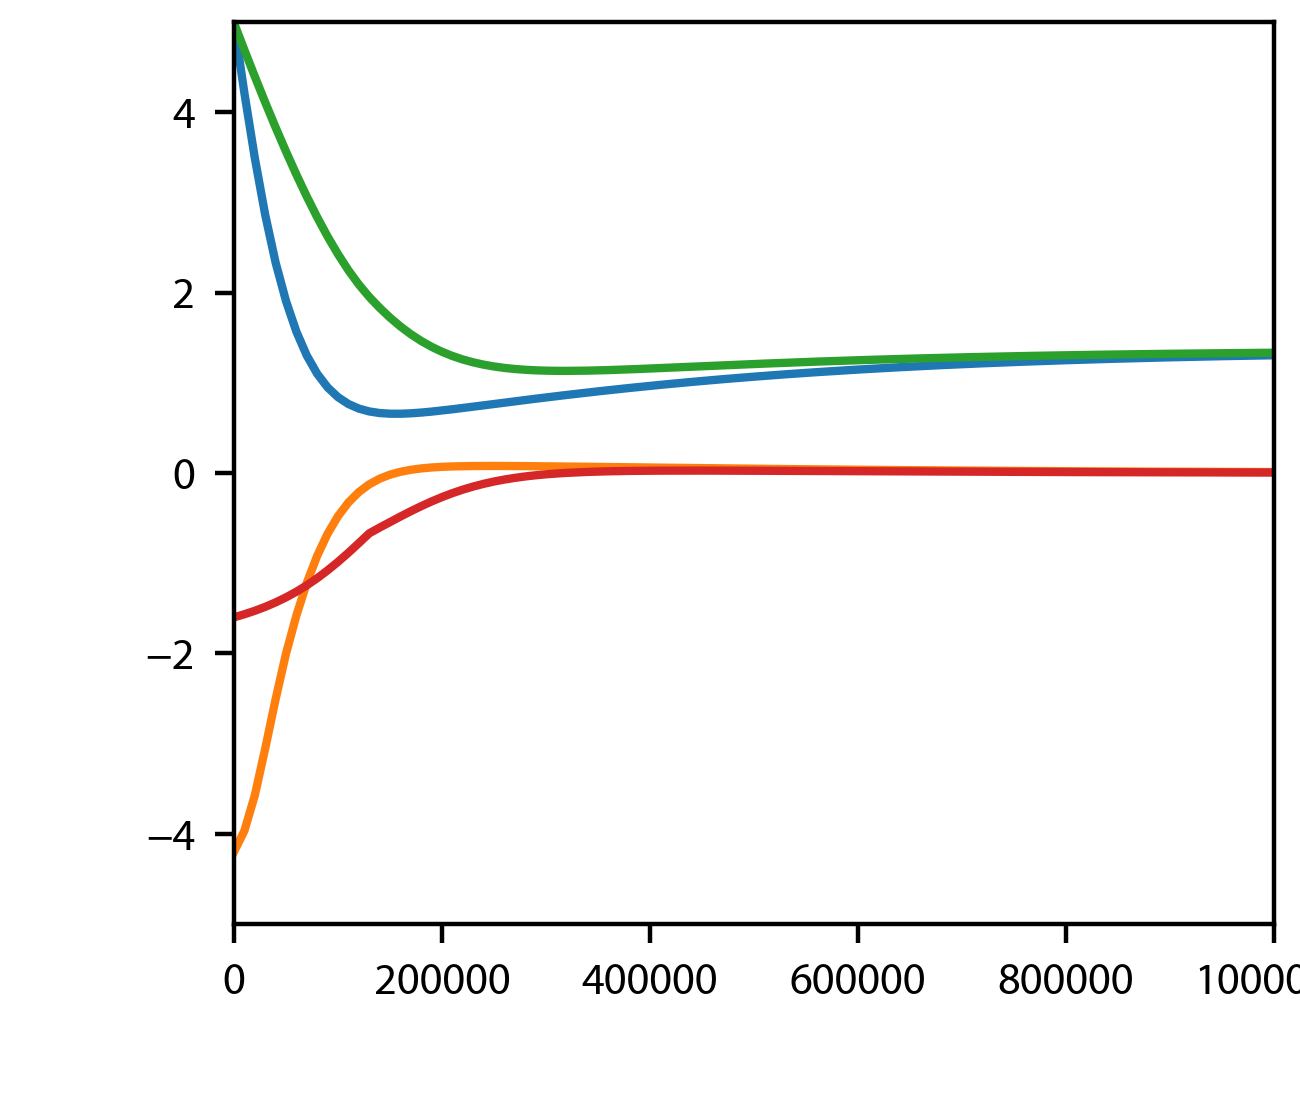

1.3594041897628573
2.3191817690399e-09


In [98]:
# Figure out where the z trajectories damp to, so that I can redo the force profiles in that
# plane.
s_toplot = "$^{171}$Yb"
plt.figure()
ii = 2
axis = axis_list[ii]
plt.plot(t,x_scale[s_toplot]*solsGMOT[(s_toplot,axis)][0,1,:])
plt.plot(t,solsGMOT[(s_toplot,axis)][0,0,:])
plt.plot(t,x_scale[s_toplot]*solsGMOT[(s_toplot,axis)][-1,1,:])
plt.plot(t,solsGMOT[(s_toplot,axis)][-1,0,:])
plt.ylim(-5.0,5.0)
plt.xlim(0,1e6)
# print((grad[ii]*100*muB/gammaHz)*sols87[axis][0,-1,1])
# print((grad[ii]*100*muB/gammaHz)*sols87[axis][-1,-1,1])
print(np.average(x_scale[s_toplot]*solsGMOT[(s_toplot,axis)][:,1,-1]))
print(np.std(x_scale[s_toplot]*solsGMOT[(s_toplot,axis)][:,1,-1]))
# for ii in np.arange(11):
#     print(V[45+ii,0])

<IPython.core.display.Javascript object>


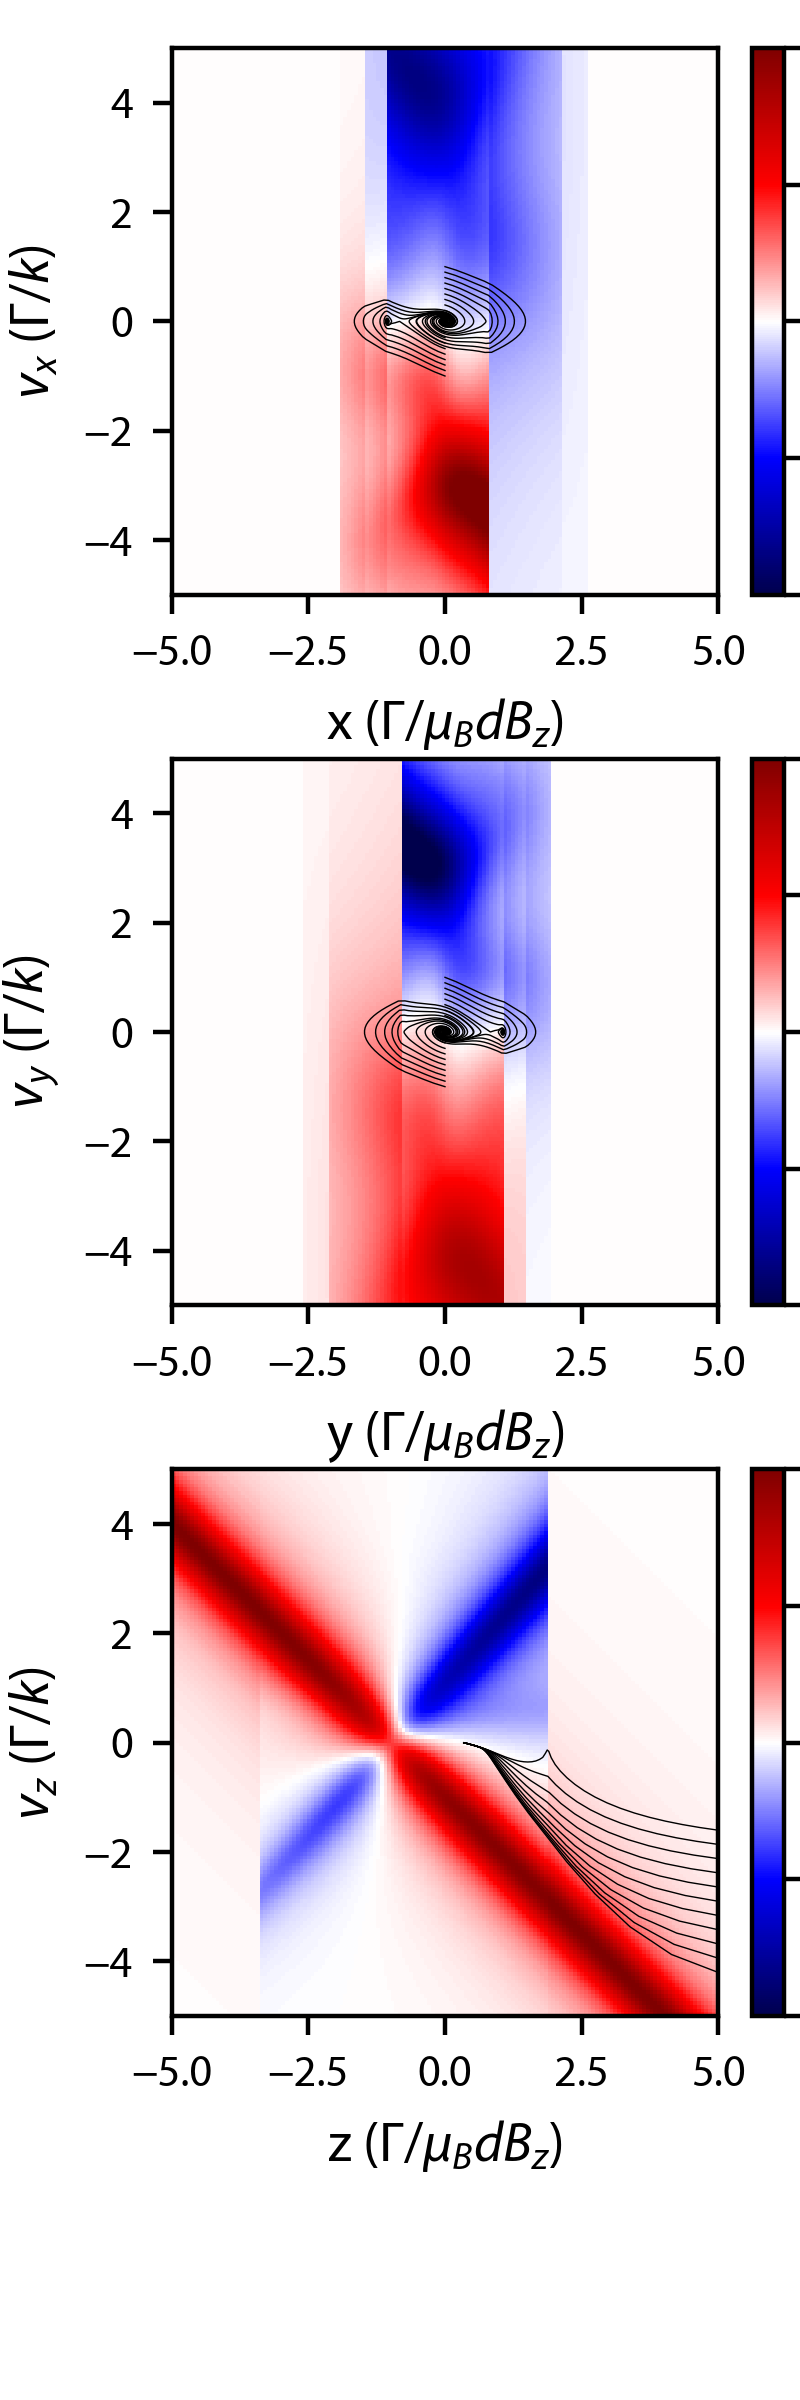

In [115]:
fig = plt.figure()
fig.set_size_inches((2.0,6))
gs = gridspec.GridSpec(3,2,hspace=0.3,wspace=0.02, width_ratios=(19,1))

#v = np.arange(-5.0, 5.01, 0.05)

s_toplot = "$^{87}$Sr"
ax=[0,0,0]
cax=[0,0,0]
for ii, axis in enumerate(axis_list):
    ax[ii] = fig.add_subplot(gs[ii,0])
    cax[ii] = fig.add_subplot(gs[ii,1])
    fmax=np.amax(np.abs(trapGMOT[(s_toplot,axis)].profile['F_v,'+axis].F[ii]))
    cax_lim = np.round(fmax, decimals = 2)
#     im = ax[ii].imshow(np.nan_to_num(trapGMOT[(s_toplot,axis)].profile['F_v,'+axis].F[ii], nan=1), \
#                        norm=colors.DivergingNorm(vcenter=0,vmin=-cax_lim,vmax=cax_lim), \
#                        origin='lower', extent=[np.round(np.min(v)),np.round(np.max(v)), \
#                                                np.round(np.min(v)),np.round(np.max(v))], \
#                        interpolation='none', cmap='seismic')
    im = ax[ii].imshow(interp_img_GMOT[(s_toplot,axis)], \
                       norm=colors.DivergingNorm(vcenter=0,vmin=-cax_lim,vmax=cax_lim), \
                       origin='lower', extent=[np.round(np.min(v)),np.round(np.max(v)), \
                                               np.round(np.min(v)),np.round(np.max(v))], \
                       interpolation='none', cmap='seismic')
    for sol in solsGMOT[(s_toplot,axis)]:
        ind = np.argwhere((np.abs(x_scale[s_toplot]*sol[1,:])<5.0) &
                          (np.abs(sol[0,:])<5.0))
        ax[ii].plot(x_scale[s_toplot]*sol[1,ind],
                    sol[0,ind],
                    linestyle='-', linewidth=0.25, color='black')
    cbar = plt.colorbar(im, cax=cax[ii])
    cbar.set_label('F ($\hbar k \Gamma$)')
    cbar.set_ticks([-cax_lim, -cax_lim/2, 0, cax_lim/2, cax_lim])
    #cax[ii].xaxis.set_label_coords(cax_lim,-cax_lim)
#     ax[ii].axvline(x=-beamWid[ii]*(grad[2]*muB)/gammaHz[s_toplot], linestyle = '--', \
#                    linewidth = 0.75, color = 'black')
#     if axis == 'x' or axis == 'y':
#         ax[ii].axvline(x=beamWid[ii]*(grad[2]*muB)/gammaHz[s_toplot], linestyle = '--', \
#                        linewidth = 0.75, color = 'black')
#     if axis == 'x' or axis == 'y':
#         ax[ii].add_patch(matplotlib.patches.Circle((0,0), 1.75, linestyle = '--', \
#                                                    linewidth = 0.75, color = 'red', \
#                                                    fill = False))
    ax[ii].set_xlabel(axis+' ($\Gamma/\mu_B dB_z$)', fontsize=10)
    ax[ii].set_ylabel('$v_'+axis+'$ ($\Gamma/k$)', fontsize=10)

if s_toplot == "$^{88}$Sr":
    plt.savefig('Sr88_GMOT_mag.png', format='png', dpi=200, bbox_inches='tight')
elif s_toplot == "$^{87}$Sr":
    plt.savefig('Sr87_GMOT_mag.png', format='png', dpi=200, bbox_inches='tight')
elif s_toplot == "$^{174}$Yb":
    plt.savefig('Yb174_GMOT_mag.png', format='png', dpi=200, bbox_inches='tight')
elif s_toplot == "$^{171}$Yb":
    plt.savefig('Yb171_GMOT_mag.png', format='png', dpi=200, bbox_inches='tight')

### Diffraction Angle Analysis

In [7]:
"""
Now, let's consider the full phase space for each spatial direction in a gMOT:
"""
angle_list = np.pi*np.array([25.,30.,35.,40.,45.,50.])/180
trapAng = {}

# Simple plane wave beams:
#BeamsGMOT = grating_MOT_beams(det, beta, Nb, thd, eta=eta, grating_angle=g_angle)
# For fancy beams, need to put GMOT definition inside the loop.
species = "$^{87}$Sr"

# First, define the coordinate system:
z = np.linspace(-5.0, 5.0, 150)
v = np.linspace(-5.0, 5.0, 150)
Z, V = np.meshgrid(z, v)
#trap_zpos = {"$^{88}$Sr":0.129, "$^{87}$Sr":0.593,"$^{171}$Yb":0.787} # for plane wave beams
#trap_zpos = {"$^{88}$Sr":0.640, "$^{87}$Sr":1.091,"$^{171}$Yb":1.433} # for clipped beams, with eta0=None
# trap_zpos = {angle_list[0]: 0.050, angle_list[1]: 0.114, angle_list[2]: 0.180,
#              angle_list[3]: 0.263, angle_list[4]: 0.366} # expand about the origin
trap_zpos = {}

for thd_i in angle_list:
    # Use fancy clipped gaussian beams:
    zchip = 0.95*(grad[2]*muB)/gammaHz[species]
    wbin = beamRad*(grad[2]*muB)/gammaHz[species]
    rstop = 1.1*(grad[2]*muB)/gammaHz[species]
    aperture = 0.15*(grad[2]*muB)/gammaHz[species]
    BeamsAng = maskedGaussianGratingMOTBeams(delta=det, s=beta, nr=Nb, thd=thd_i, eta=eta, eta0=None, \
                                             wb=wbin, rs=rstop, center_hole=aperture, outer_radius=rstop, \
                                             zgrating=zchip, grating_angle=g_angle)
    trapAng[thd_i] = pylcp.trap_rateeq(BeamsAng, mag_field, hamiltonian[species],
                                       include_mag_forces=False)
    trap_zpos[thd_i] = trapAng[thd_i].find_equilibrium_position(upper_lim=2.0, lower_lim=0.0, Npts=101)[2]
    print(trap_zpos[thd_i])
    for ii, axis in enumerate(axis_list):
        if axis == 'x':
            # expand about origin
            #pos_list = [Z, np.zeros(Z.shape), np.zeros(Z.shape)]
            # expand about trap location
            pos_list = [Z, np.zeros(Z.shape), np.full(Z.shape, trap_zpos[thd_i])]
            v_list = [V, np.zeros(Z.shape), np.zeros(Z.shape)]
        elif axis == 'y':
            # expand about origin
            #pos_list = [np.zeros(Z.shape), Z, np.zeros(Z.shape)]
            # expand about trap location
            pos_list = [np.zeros(Z.shape), Z, np.full(Z.shape, trap_zpos[thd_i])]
            v_list = [np.zeros(Z.shape), V, np.zeros(Z.shape)]
        else:
            pos_list = [np.zeros(Z.shape), np.zeros(Z.shape), Z]
            v_list = [np.zeros(Z.shape), np.zeros(Z.shape), V]
        trapAng[thd_i].generate_force_profile(pos_list, v_list, name='F_v,'+axis)

/Users/daniel/Documents/GitHub/packages/pylcp/rateeq.py:215: ComplexWarning: Casting complex values to real discards the imaginary part
  np.dot(kvec, v))**2)


0.3262038356507486
0.3726120409924434
0.4402163016858217
0.5261734895924413
0.6301836736484702
0.7532065344922692


In [8]:
# interpolate x, v force profile:
fAng = {}
interp_img_Ang = {}
for thd_i in angle_list:
    for ii, axis in enumerate(axis_list):
        trapAng[thd_i].profile['F_v,'+axis].F[ii] = np.nan_to_num(trapAng[thd_i].profile['F_v,'+axis].F[ii])
        print(np.any(np.isnan(trapAng[thd_i].profile['F_v,'+axis].F[ii])))
#         fAng[(thd_i, axis)] = interp2d(V, Z, \
#                                        trapAng[(thd_i, axis)].profile['F_v,'+axis].F[ii])
        fAng[(thd_i, axis)] = RectBivariateSpline(v, z,
                                                  trapAng[thd_i].profile['F_v,'+axis].F[ii],
                                                  kx=3, ky=3)
        interp_img_Ang[(thd_i, axis)] = fAng[(thd_i, axis)](v, z)#.transpose()
        print(np.sum(np.abs(interp_img_Ang[(thd_i, axis)]-trapAng[thd_i].profile['F_v,'+axis].F[ii])))

False
1.650265995928085e-14
False
1.6943181896602313e-14
False
1.816264407074981e-13
False
1.9634264737915674e-14
False
1.9125197927181313e-14
False
1.755917070409398e-13
False
2.1344372414710352e-14
False
2.2148133028038222e-14
False
1.7819439280126461e-13
False
2.407746847528374e-14
False
2.4990977824508176e-14
False
1.8684558837200188e-13
False
2.7186074798657755e-14
False
2.7419900931748925e-14
False
1.8884474198158432e-13
False
3.1298613570216216e-14
False
3.1934098839655706e-14
False
1.8914191502079902e-13


In [9]:
# use solve_ivp to integrate motion

# iterate over initial conditions and axes:
solsAng = {}
#solsAng_em = {}
#t = np.linspace(0,25e-3,501) # for SI units
t = np.linspace(0,5e6,501) # for scaled units
span = [t[0],t[-1]]
solver='DOP853'
for thd_i in angle_list:
    # grid of initial values for x and y:
    x = 0
    #vx = (gamma[species]/kvec[species])*np.linspace(-1.0, 1.0, 21) # for SI units
    vx = np.linspace(-1.0, 1.0, 21) # for scaled units
    X, VX = np.meshgrid(x, vx)
    y0 = np.column_stack((VX.reshape(-1), X.reshape(-1)))
    # grid of initial values for z:
    #x = 4.99*(gammaHz[species]/(grad[2]*100*muB)) # for SI units
    #vx = (gamma[species]/kvec[species])*np.linspace(-4.9, -1.5, 12) # for SI units
    x = 4.99 # for scaled units
    vx = np.linspace(-4.2, -1.6, 11) # for scaled units
    X, VX = np.meshgrid(x, vx)
    z0 = np.column_stack((VX.reshape(-1), X.reshape(-1)))
    for ii, axis in enumerate(axis_list):
        if axis == 'z':
            solsAng[(thd_i,axis)] = np.zeros((z0.shape[0], 2, t.shape[0]))
            #solsAng_em[(thd_i,axis)] = np.zeros((z0.shape[0], 2, t.shape[0]))
            for jj, z0_i in enumerate(z0):
                st = solve_ivp(lambda t, y: motion_des2(t, y, species, fAng[(thd_i, axis)]), \
                               span, [z0_i[0],z0_i[1]/x_scale[species]], method=solver, t_eval=t, \
                               vectorized=True, rtol=1e-9, atol=1e-12)
                solsAng[(thd_i, axis)][jj] = st.y
#                 trapGMOT[(species, axis)].set_initial_position_and_velocity(np.array([0,0,z0_i[1]]), \
#                                                                             np.array([0,0,z0_i[0]]))
#                 trapGMOT[(species, axis)].set_initial_pop_from_equilibrium()
#                 trapGMOT[(species, axis)].evolve_motion(span, mass_ratio=de_scale[species], \
#                                                         length_scale=x_scale[species], \
#                                                         freeze_axis=[True,True,False], \
#                                                         method='RK45', t_eval=t, vectorized=False, \
#                                                         rtol=1e-9, atol=1e-12)
#                 vt = trapGMOT[(species, axis)].sol.y[-6:-3]
#                 rt = trapGMOT[(species, axis)].sol.y[-3:]
#                 solsGMOT_em[(species, axis)][jj] = np.array([vt[ii],rt[ii]])
        elif axis == 'x':
            solsAng[(thd_i,axis)] = np.zeros((y0.shape[0], 2, t.shape[0]))
            #solsAng_em[(thd_i,axis)] = np.zeros((y0.shape[0], 2, t.shape[0]))
            for jj, y0_i in enumerate(y0):
                st = solve_ivp(lambda t, y: motion_des2(t, y, species, fAng[(thd_i, axis)]), \
                               span, y0_i, method=solver, t_eval=t, vectorized=True, \
                               rtol=1e-9, atol=1e-12)
                solsAng[(thd_i,axis)][jj] = st.y
#                 trapGMOT[(species, axis)].set_initial_position_and_velocity(np.array([y0_i[1],0,1e-16]), \
#                                                                             np.array([y0_i[0],0,0]))
#                 trapGMOT[(species, axis)].set_initial_pop_from_equilibrium()
#                 #print(trapGMOT[(species, axis)].N0)
#                 trapGMOT[(species, axis)].evolve_motion(span, mass_ratio=de_scale[species], \
#                                                         length_scale=x_scale[species], \
#                                                         freeze_axis=[False,True,True], \
#                                                         method='RK45', t_eval=t, vectorized=False, \
#                                                         rtol=1e-9, atol=1e-12)
#                 vt = trapGMOT[(species, axis)].sol.y[-6:-3]
#                 rt = trapGMOT[(species, axis)].sol.y[-3:]
#                 solsGMOT_em[(species, axis)][jj] = np.array([vt[ii],rt[ii]])
        else:
            solsAng[(thd_i,axis)] = np.zeros((y0.shape[0], 2, t.shape[0]))
            #solsAng_em[(thd_i,axis)] = np.zeros((y0.shape[0], 2, t.shape[0]))
            for jj, y0_i in enumerate(y0):
                st = solve_ivp(lambda t, y: motion_des2(t, y, species, fAng[(thd_i, axis)]), \
                               span, y0_i, method=solver, t_eval=t, vectorized=True, \
                               rtol=1e-9, atol=1e-12)
                solsAng[(thd_i,axis)][jj] = st.y
#                 trapGMOT[(species, axis)].set_initial_position_and_velocity(np.array([0,y0_i[1],1e-16]), \
#                                                                             np.array([0,y0_i[0],0]))
#                 trapGMOT[(species, axis)].set_initial_pop_from_equilibrium()
#                 trapGMOT[(species, axis)].evolve_motion(span, mass_ratio=de_scale[species], \
#                                                         length_scale=x_scale[species], \
#                                                         freeze_axis=[True,False,True], \
#                                                         method='RK45', t_eval=t, vectorized=False, \
#                                                         rtol=1e-9, atol=1e-12)
#                 vt = trapGMOT[(species, axis)].sol.y[-6:-3]
#                 rt = trapGMOT[(species, axis)].sol.y[-3:]
#                 solsGMOT_em[(species, axis)][jj] = np.array([vt[ii],rt[ii]])

<IPython.core.display.Javascript object>


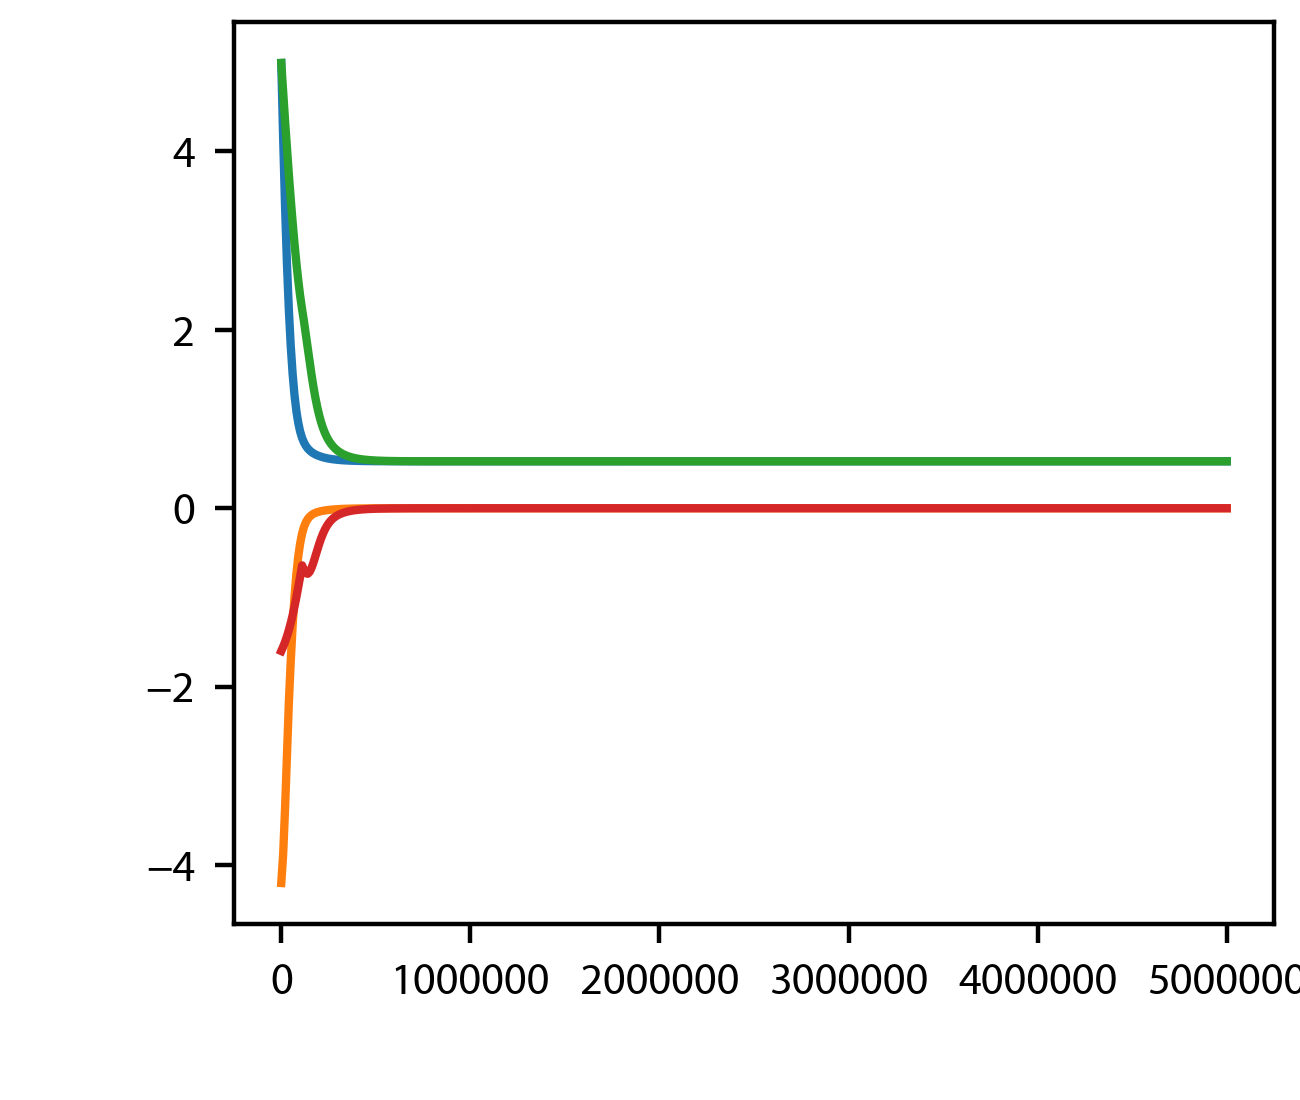

/Users/daniel/Documents/GitHub/packages/pylcp/rateeq.py:215: ComplexWarning: Casting complex values to real discards the imaginary part
  np.dot(kvec, v))**2)


[0.         0.         0.52617349]
0.5261720294737866
2.3031816318397267e-13


In [13]:
# Figure out where the z trajectories damp to, so that I can redo the force profiles in that
# plane.
s_toplot = "$^{87}$Sr"
plt.figure()
ii = 2
axis = axis_list[ii]
kk = 3
th_toplot = angle_list[kk]
plt.plot(t,x_scale[species]*solsAng[(th_toplot,axis)][0,1,:])
plt.plot(t,solsAng[(th_toplot,axis)][0,0,:])
plt.plot(t,x_scale[species]*solsAng[(th_toplot,axis)][-1,1,:])
plt.plot(t,solsAng[(th_toplot,axis)][-1,0,:])
#plt.ylim(-0.2,2.0)
# print((grad[ii]*100*muB/gammaHz)*sols87[axis][0,-1,1])
# print((grad[ii]*100*muB/gammaHz)*sols87[axis][-1,-1,1])
print(trapAng[th_toplot].find_equilibrium_position(lower_lim=0.0, upper_lim=1.5, Npts=101))
print(np.average(x_scale[species]*solsAng[(th_toplot,axis)][:,1,-1]))
print(np.std(x_scale[species]*solsAng[(th_toplot,axis)][:,1,-1]))
# for ii in np.arange(11):
#     print(V[45+ii,0])

<IPython.core.display.Javascript object>


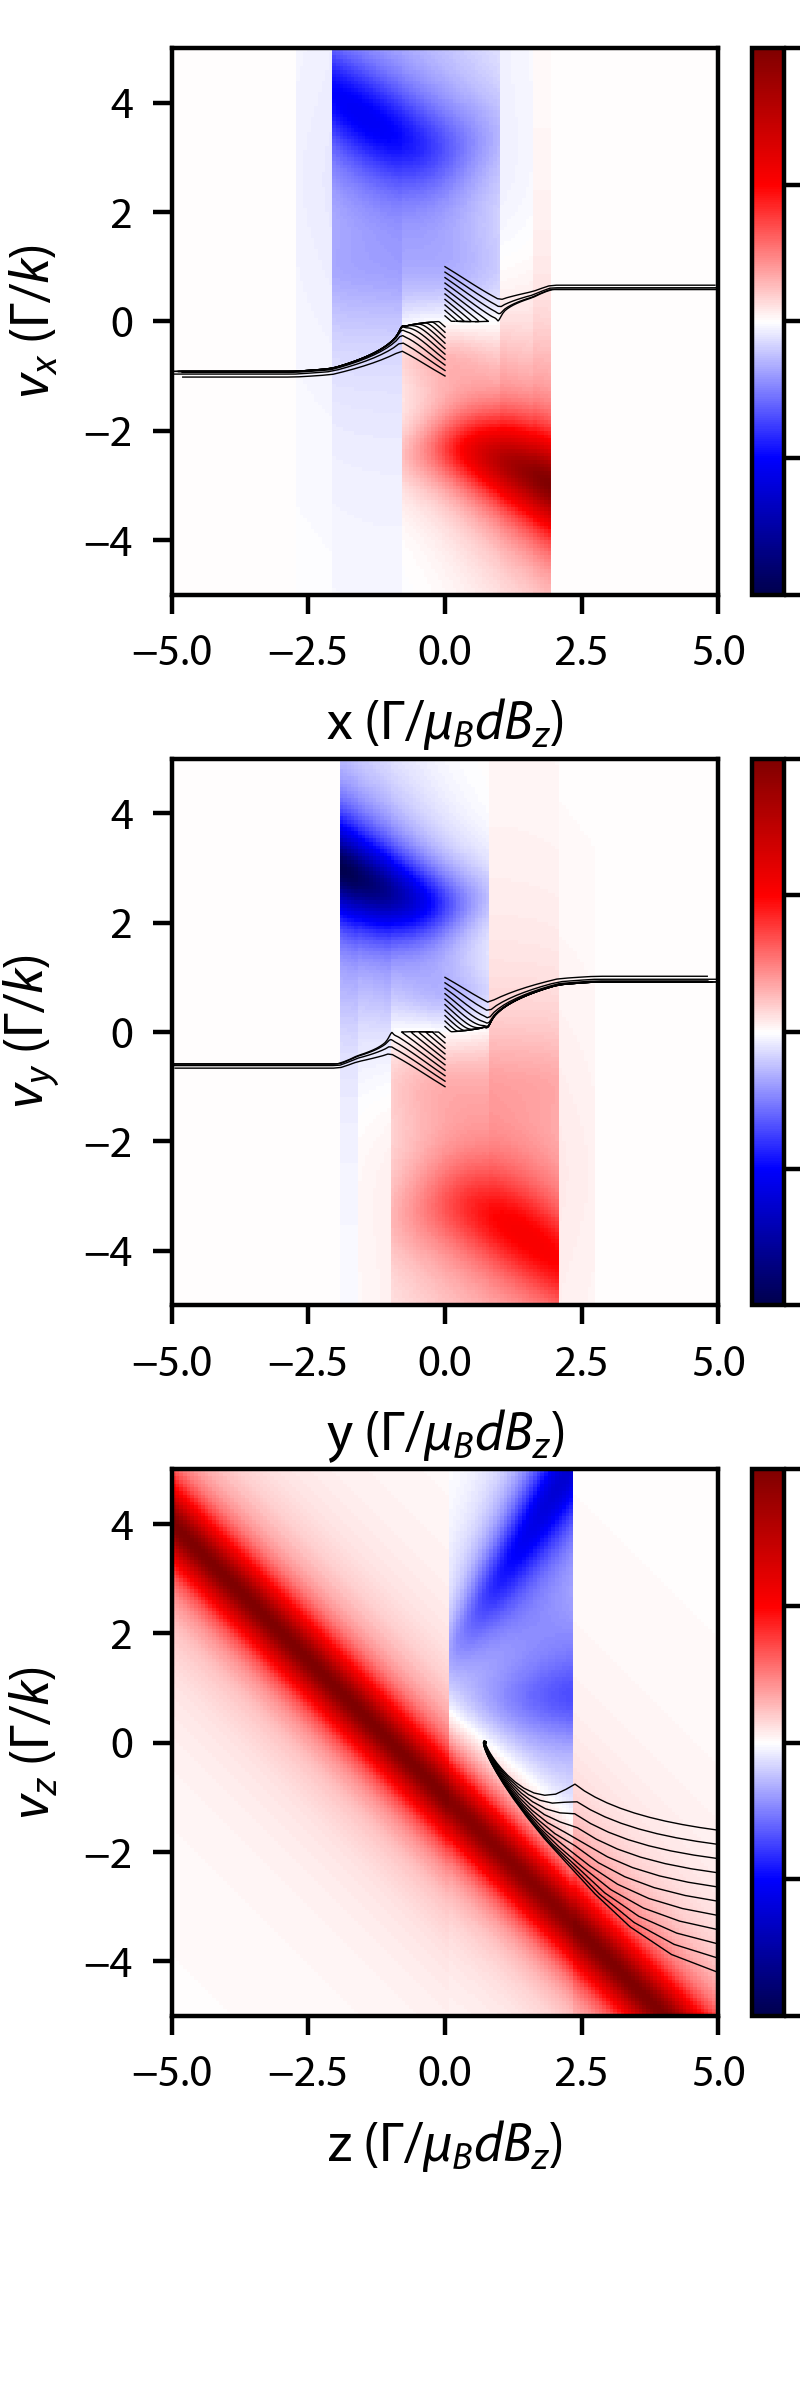

In [22]:
fig = plt.figure()
fig.set_size_inches((2.0,6))
gs = gridspec.GridSpec(3,2,hspace=0.3,wspace=0.02, width_ratios=(19,1))

#v = np.arange(-5.0, 5.01, 0.05)

s_toplot = "$^{87}$Sr"
kk = 5
th_toplot = angle_list[kk]
ax=[0,0,0]
cax=[0,0,0]
for ii, axis in enumerate(axis_list):
    ax[ii] = fig.add_subplot(gs[ii,0])
    cax[ii] = fig.add_subplot(gs[ii,1])
    fmax=np.amax(np.abs(trapAng[th_toplot].profile['F_v,'+axis].F[ii]))
    cax_lim = np.round(fmax, decimals = 2)
    im = ax[ii].imshow(np.nan_to_num(trapAng[th_toplot].profile['F_v,'+axis].F[ii], nan=1), \
                       norm=colors.DivergingNorm(vcenter=0,vmin=-cax_lim,vmax=cax_lim), \
                       origin='lower', extent=[np.round(np.min(v)),np.round(np.max(v)), \
                                               np.round(np.min(v)),np.round(np.max(v))], \
                       interpolation='none', cmap='seismic')
#     im = ax[ii].imshow(interp_img_Ang[(th_toplot,axis)], \
#                        norm=colors.DivergingNorm(vcenter=0,vmin=-cax_lim,vmax=cax_lim), \
#                        origin='lower', extent=[np.round(np.min(v)),np.round(np.max(v)), \
#                                                np.round(np.min(v)),np.round(np.max(v))], \
#                        interpolation='none', cmap='seismic')
    for sol in solsAng[(th_toplot,axis)]:
        ind = np.argwhere((np.abs(x_scale[species]*sol[1,:])<5.0) &
                          (np.abs(sol[0,:])<5.0))
        ax[ii].plot(x_scale[species]*sol[1,ind],
                    sol[0,ind],
                    linestyle='-', linewidth=0.25, color='black')
    cbar = plt.colorbar(im, cax=cax[ii])
    cbar.set_label('F ($\hbar k \Gamma$)')
    cbar.set_ticks([-cax_lim, -cax_lim/2, 0, cax_lim/2, cax_lim])
    #cax[ii].xaxis.set_label_coords(cax_lim,-cax_lim)
#     ax[ii].axvline(x=-beamWid[ii]*(grad[2]*muB)/gammaHz[s_toplot], linestyle = '--', \
#                    linewidth = 0.75, color = 'black')
#     if axis == 'x' or axis == 'y':
#         ax[ii].axvline(x=beamWid[ii]*(grad[2]*muB)/gammaHz[s_toplot], linestyle = '--', \
#                        linewidth = 0.75, color = 'black')
#     if axis == 'x' or axis == 'y':
#         ax[ii].add_patch(matplotlib.patches.Circle((0,0), 1.75, linestyle = '--', \
#                                                    linewidth = 0.75, color = 'red', \
#                                                    fill = False))
    ax[ii].set_xlabel(axis+' ($\Gamma/\mu_B dB_z$)', fontsize=10)
    ax[ii].set_ylabel('$v_'+axis+'$ ($\Gamma/k$)', fontsize=10)

if s_toplot == "$^{88}$Sr":
    plt.savefig('Sr88_Angle.png', format='png', dpi=200, bbox_inches='tight')
elif s_toplot == "$^{87}$Sr":
    plt.savefig('Sr87_Angle.png', format='png', dpi=200, bbox_inches='tight')
elif s_toplot == "$^{171}$Yb":
    plt.savefig('Yb171_Angle.png', format='png', dpi=200, bbox_inches='tight')

### Escape Velocities

In [26]:
# Define event functions for evolve_motion:
def origin_return(t, y, length_scale, trap_center): # args are passed to events! 
    v = y[-6:-3]
    r = (y[-3:]-trap_center)*length_scale
    return (np.sqrt(np.dot(r, r)+np.dot(v, v)) - 0.1)
# Make a function to check overlap of MOT beams:
def beam_overlap(t, y, beams):
    # beams is a laserBeams object:
    r = y[-3:]
    olap = np.prod(beams.beta(r, t), axis=0, keepdims=True)
    olap[olap == 0] = -1
    return olap

In [29]:
def find_escape_velocity(trap, th_i, phi_i, z_0, scale, laserbeams):
    import numpy as np
    # Define event functions for evolve_motion:
    def origin_return(t, y, length_scale, trap_center): # args are passed to events! 
        v = y[-6:-3]
        r = (y[-3:]-trap_center)*length_scale
        return (np.sqrt(np.dot(r, r)+np.dot(v, v)) - 0.1)
    # Make a function to check overlap of MOT beams:
    def beam_overlap(t, y, beams):
        # beams is a laserBeams object:
        r = y[-3:]
        olap = np.prod(beams.beta(r, t), axis=0, keepdims=True)
        olap[olap == 0] = -1
        return olap
    r_0 = np.array([0,0,z_0])
    # define trap escape event:
    escape = lambda t, y: beam_overlap(t, y, laserbeams)
    escape.terminal = True
    escape.direction = -1
    # define recapture event:
    capture = lambda t, y: origin_return(t, y, scale, r_0)
    capture.terminal = True
    capture.direction = -1
    # initial guess for escape velocity:
    v_esc = 0
    esc_sol = None
    v_guess = 1.25
    v_step = v_guess/2
    levels = 5
    for kk in np.arange(levels):
        v_g = np.array([v_guess*np.sin(th_i)*np.cos(phi_i),
                        v_guess*np.sin(th_i)*np.sin(phi_i),
                        v_guess*np.cos(th_i)])
        trap.set_initial_position_and_velocity(r_0, v_g)
        trap.set_initial_pop_from_equilibrium()
        trap.evolve_motion([0, 2e6], recoil_velocity=scale, method='RK45', t_eval=np.linspace(0,2e6,200), vectorized=False,
                           events=(capture, escape), rtol=1e-6, atol=1e-9)
        if trap.sol.t_events[1].size == 0:
            # atom did not escape, so go to higher velocity:
            v_esc = v_guess
            esc_sol = trap.sol
            print('recaptured ' + str(v_guess))
            v_guess += v_step
        else:
            # atom left the beam overlap region, so go to lower velocity:
            print('lost ' + str(v_guess))
            v_guess -= v_step
        v_step = v_step/2
        # Don't integrate below the cutoff:
        if v_guess <= 0.1:
            break
    return esc_sol, v_esc

In [30]:
# use solve_ivp to integrate motion

# iterate over initial conditions and axes:
solsEsc = {}
trapEsc = {}
zpos_Esc = {}
#esc_vel = {}
df = pd.DataFrame(columns=['species', 'th_d', 'zchip', 'th_m', 'phi_m', 'v_esc'])
# Use scaled units for time:
t = np.linspace(0,2e6,200) # for scaled units
span = [t[0],t[-1]]
solver='RK45'
# set species:
species = "$^{88}$Sr"
# List of conditions to test:
angle_list = np.pi*np.array([25., 30., 35., 40., 45., 50.])/180
zchip_list = np.array([0.5, 0.75, 1.0])*1e-2*kvec[species]
# list of measured theta and phi:
th_m = np.pi*np.linspace(0,1,5)
phi_m = np.pi*np.linspace(0,1/3,4)
# iterate over diffraction angles and chip positions:
for thd_i in angle_list:
    for zchip_i in zchip_list:
        # array to store escape velocities:
        #esc_vel[(thd_i,zchip_i)] = np.zeros((th_m.size, phi_m.size))
        # Use fancy clipped gaussian beams:
        wbin = beamRad*1e-2*kvec[species]
        rstop = 1.1*1e-2*kvec[species]
        aperture = 0.15*1e-2*kvec[species]
        BeamsAng = maskedGaussianGratingMOTBeams(delta=det, s=beta, nr=Nb, thd=thd_i, eta=eta, eta0=None, \
                                                 wb=wbin, rs=rstop, center_hole=aperture, outer_radius=rstop, \
                                                 zgrating=zchip_i, grating_angle=0)
        FieldAng = quadrupoleMagneticField(x_scale[species])
        trapEsc[(thd_i,zchip_i)] = pylcp.trap_rateeq(BeamsAng, FieldAng, hamiltonian[species],
                                                     include_mag_forces=False)
        zpos_Esc[(thd_i,zchip_i)] = trapEsc[(thd_i,zchip_i)].find_equilibrium_position(upper_lim=zchip_i,
                                                                                       lower_lim=0.0,
                                                                                       Npts=101)[2]
        print(zpos_Esc[(thd_i,zchip_i)]*x_scale[species])
        # loop over theta and phi:
        for ii, th_i in enumerate(th_m):
            ts = time.time() 
            with pathos.pools.ProcessPool(nodes=4) as pool:
                sols, v_escs = zip(*pool.map(find_escape_velocity,
                                            [trapEsc[(thd_i,zchip_i)], trapEsc[(thd_i,zchip_i)],
                                             trapEsc[(thd_i,zchip_i)], trapEsc[(thd_i,zchip_i)]],
                                            [th_i, th_i, th_i, th_i], 
                                            phi_m,
                                            [zpos_Esc[(thd_i,zchip_i)], zpos_Esc[(thd_i,zchip_i)],
                                             zpos_Esc[(thd_i,zchip_i)], zpos_Esc[(thd_i,zchip_i)]],
                                            [de_scale[species], de_scale[species],
                                             de_scale[species], de_scale[species]],
                                            [BeamsAng, BeamsAng,
                                             BeamsAng, BeamsAng]))
            tm = time.time()
            print('Integrating took '+str((tm-ts)/3600)+' hours')
            for kk, v in enumerate(v_escs):
                dft = pd.DataFrame([[species, thd_i, zchip_i, th_i, phi_m[kk], v]],
                               columns=['species', 'th_d', 'zchip', 'th_m', 'phi_m', 'v_esc'])
                df = df.append(dft, ignore_index=True)
                if sols[kk] is not None:
                    vt = sols[kk].v
                    rt = sols[kk].r
                    solsEsc[(thd_i,zchip_i,th_i,phi_m[kk],v)] = np.array([vt,rt])
                else:
                    solsEsc[(thd_i,zchip_i,th_i,phi_m[kk],v)] = None
            te = time.time()
            print('Theta '+str(ii)+' took '+str((te-ts)/3600)+' hours')
                
if species == "$^{88}$Sr":
    df.to_csv('Sr88_escape_velocity.csv')
elif species == "$^{87}$Sr":
    df.to_csv('Sr87_escape_velocity.csv')
elif species == "$^{174}$Yb":
    df.to_csv('Yb174_escape_velocity.csv')
elif species == "$^{171}$Yb":
    df.to_csv('Yb171_escape_velocity.csv')

0.37491846290844877
Integrating took 1.7966251208384831 hours
Theta 0 took 1.7966270652744505 hours
Integrating took 0.05014912121825748 hours
Theta 1 took 0.05015189905961354 hours
Integrating took 0.04762768910990821 hours
Theta 2 took 0.04763019601504008 hours
Integrating took 0.09743151757452223 hours
Theta 3 took 0.09743401083681319 hours
Integrating took 6.316170930597517 hours
Theta 4 took 6.316170930597517 hours
0.5920684400515283
Integrating took 1.7288570055034425 hours
Theta 0 took 1.7288570055034425 hours
Integrating took 1.1759218392769495 hours
Theta 1 took 1.1759246240721808 hours
Integrating took 1.456302335659663 hours
Theta 2 took 1.456302335659663 hours
Integrating took 0.9692901070250405 hours
Theta 3 took 0.9692901070250405 hours
Integrating took 4.560365293953154 hours
Theta 4 took 4.560368078417248 hours
0.8345255062720147
Integrating took 3.3763782401217353 hours
Theta 0 took 3.376381011605263 hours
Integrating took 1.843801502916548 hours
Theta 1 took 1.8438015

<IPython.core.display.Javascript object>


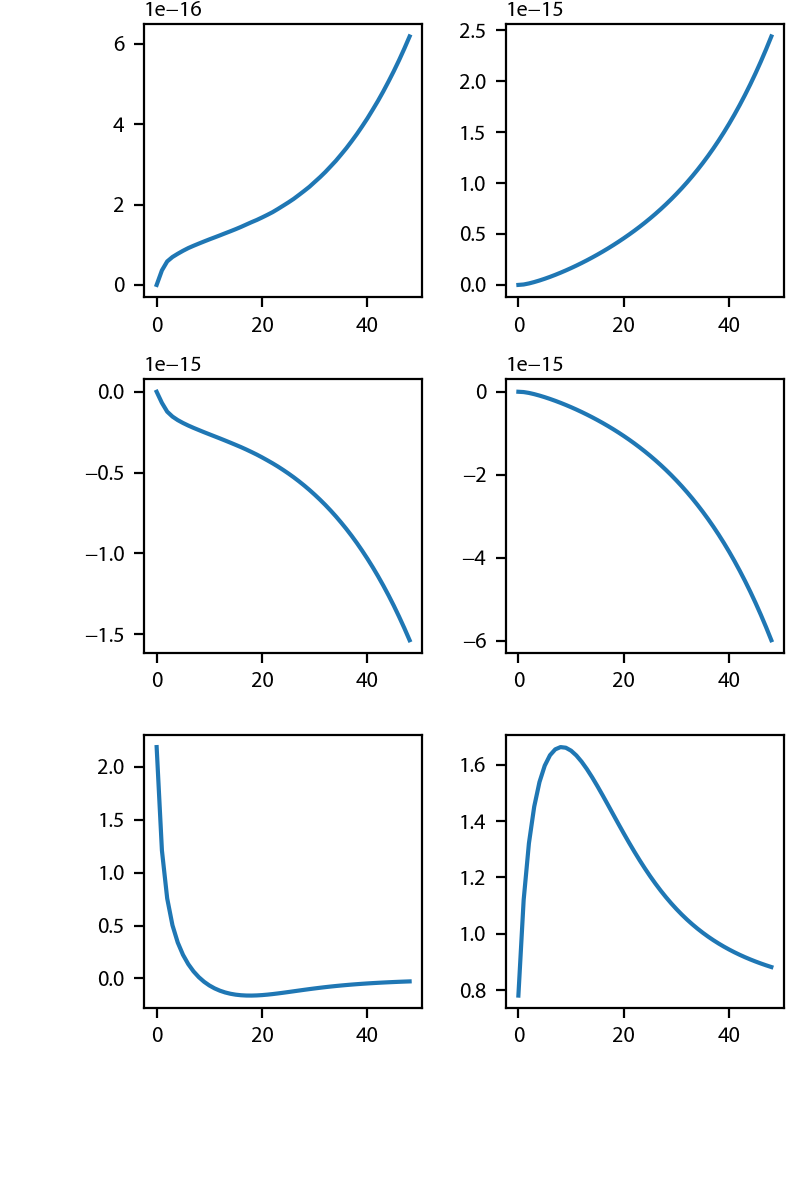

In [17]:
fig = plt.figure()
fig.set_size_inches((4.0,6.0))
gs = gridspec.GridSpec(3,2,hspace=0.3,wspace=0.3, width_ratios=(1,1))

#v = np.arange(-5.0, 5.01, 0.05)

s_toplot = "$^{88}$Sr"
zchip_tp = zchip_list[0]
angle_tp = angle_list[0]
th_tp = th_m[0]
phi_tp = phi_m[0]
v_guess_tp = 2.1875
ax=[[0,0],[0,0],[0,0]]
for ii, axis in enumerate(axis_list):
    ax[ii][0] = fig.add_subplot(gs[ii,0])
    ax[ii][1] = fig.add_subplot(gs[ii,1])
    ax[ii][0].plot(solsEsc[(angle_tp,zchip_tp,th_tp,phi_tp,v_guess_tp)][0,ii])
    ax[ii][1].plot(x_scale[s_toplot]*solsEsc[(angle_tp,zchip_tp,th_tp,phi_tp,v_guess_tp)][1,ii])
#print(esc_vel[(angle_tp,zchip_tp)][0, 0])
# if s_toplot == "$^{88}$Sr":
#     plt.savefig('Sr88_GMOT_mag.png', format='png', dpi=200, bbox_inches='tight')
# elif s_toplot == "$^{87}$Sr":
#     plt.savefig('Sr87_GMOT_mag.png', format='png', dpi=200, bbox_inches='tight')
# elif s_toplot == "$^{174}$Yb":
#     plt.savefig('Yb174_GMOT_mag.png', format='png', dpi=200, bbox_inches='tight')
# elif s_toplot == "$^{171}$Yb":
#     plt.savefig('Yb171_GMOT_mag.png', format='png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


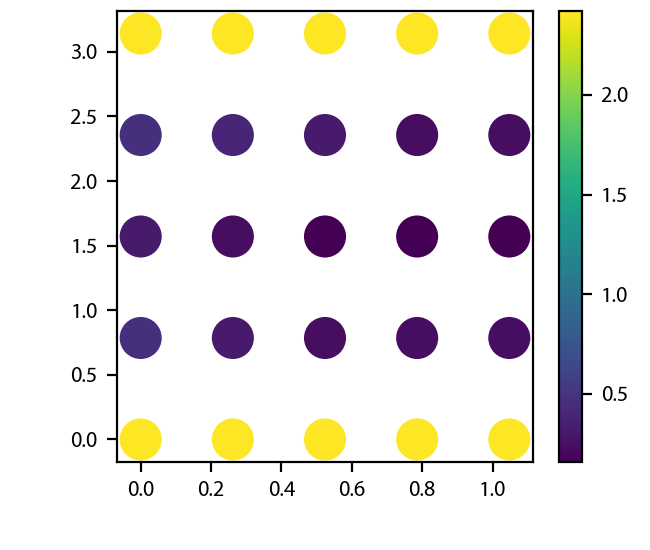

In [18]:
fig, ax = plt.subplots()
scat = ax.scatter(df['phi_m'], df['th_m'], c=df['v_esc'], s=200)
fig.colorbar(scat)
ax.margins(0.05)

In [ ]:
# use solve_ivp to integrate motion

# iterate over initial conditions and axes:
trapEsc = {}
zpos_Esc = {}
#df = pd.DataFrame(columns=['species', 'th_d', 'zchip', 'th_m', 'phi_m', 'v_esc'])
# Use scaled units for time:
t = np.linspace(0,2e6,200) # for scaled units
span = [t[0],t[-1]]
solver='RK45'
# set species:
species = "$^{87}$Sr"
# List of conditions to test:
angle_list = np.pi*np.array([25., 30., 35., 40., 45., 50.])/180
zchip_list = np.array([0.5, 0.75, 1.0])*1e-2*kvec[species]
# list of measured theta and phi:
th_m = np.pi*np.linspace(0,1,5)
phi_m = np.pi*np.linspace(0,1/3,4)
# iterate over diffraction angles and chip positions:
for thd_i in angle_list:
    for zchip_i in zchip_list:
        # Use fancy clipped gaussian beams:
        wbin = beamRad*1e-2*kvec[species]
        rstop = 1.1*1e-2*kvec[species]
        aperture = 0.15*1e-2*kvec[species]
        BeamsAng = maskedGaussianGratingMOTBeams(delta=det, s=beta, nr=Nb, thd=thd_i, eta=eta, eta0=None, \
                                                 wb=wbin, rs=rstop, center_hole=aperture, outer_radius=rstop, \
                                                 zgrating=zchip_i, grating_angle=0)
        FieldAng = quadrupoleMagneticField(x_scale[species])
        trapEsc[(thd_i,zchip_i)] = pylcp.trap_rateeq(BeamsAng, FieldAng, hamiltonian[species],
                                                     include_mag_forces=False)
        zpos_Esc[(thd_i,zchip_i)] = trapEsc[(thd_i,zchip_i)].find_equilibrium_position(upper_lim=zchip_i,
                                                                                       lower_lim=-0.5,
                                                                                       Npts=101)[2]
        print(zpos_Esc[(thd_i,zchip_i)]*x_scale[species])
        #print(trapEsc[(thd_i,zchip_i)].laserBeams)
# pickle with dill:
with open('parameters.pkl', 'wb') as output:
    dill.dump(trapEsc, output)
    dill.dump(zpos_Esc, output)
    dill.dump((species, de_scale[species], angle_list, zchip_list, th_m, phi_m), output)

### Damping Coefficients

In [69]:
species = '$^{88}$Sr'
for species in species_list:
    for ii, axis in enumerate(axis_list):
        Alpha = trapGMOT[(species, axis)].damping_coeff(axes=[ii], r=np.array([0,0,trap_zpos[species]]))
        print(species)
        print(Alpha)

$^{88}$Sr
[0.01049294]
$^{88}$Sr
[0.01049294]
$^{88}$Sr
[0.18751448]
$^{87}$Sr
[0.009612]
$^{87}$Sr
[0.009612]
$^{87}$Sr
[0.18067529]
$^{171}$Yb
[0.0097869]
$^{171}$Yb
[0.0097869]
$^{171}$Yb
[0.17964844]


## Make Figures

<IPython.core.display.Javascript object>


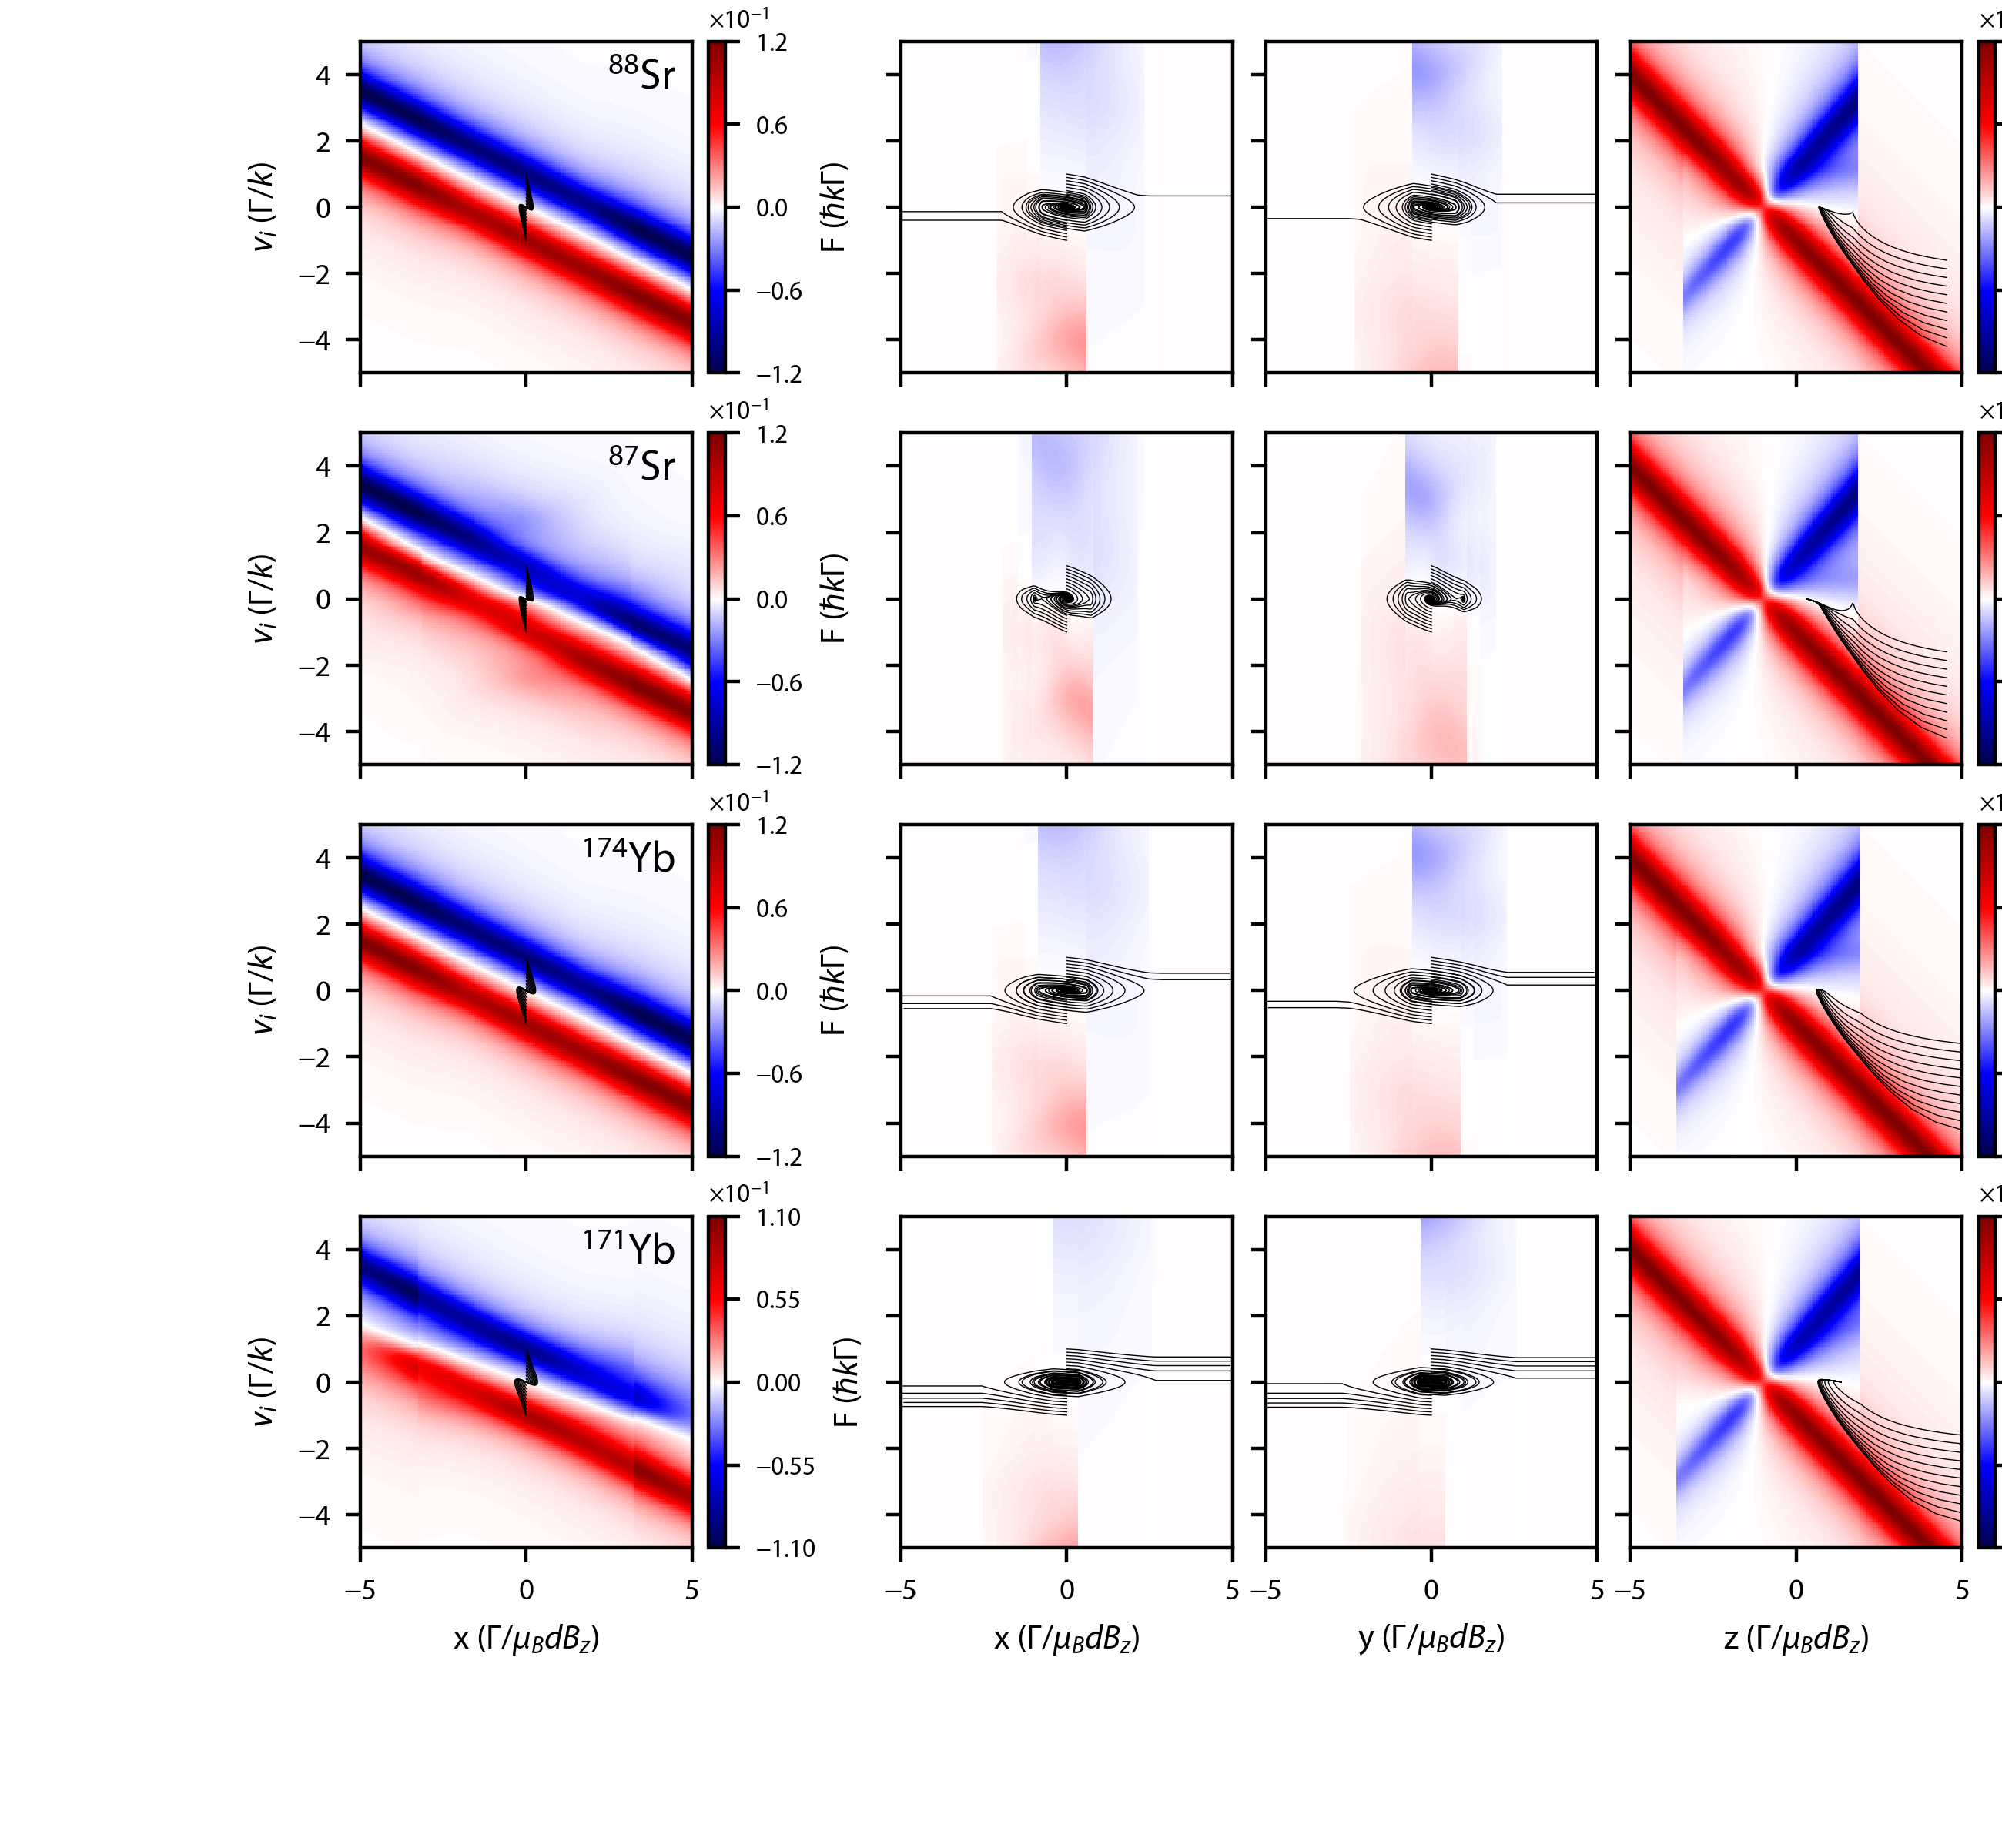

In [114]:
fig = plt.figure()
pw = 19
nrows, ncols = 4, 4
fig.set_size_inches((6.5,1.5*nrows))
gs = gridspec.GridSpec(nrows, 2, hspace=0.15, wspace=0.3, width_ratios=(1.0,3.2))
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))

#v = np.arange(-5.0, 5.01, 0.05)

gs_sub=[None]*nrows
ax=[None]*nrows*ncols
cax=[None]*2*nrows
for jj, species in enumerate(species_list):
    gs_sub[jj] = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=gs[jj,1],\
                                                          wspace=0.1,\
                                                          width_ratios=(1,1,1))
    axN = 0
    ax3D = axis_list[axN]
    if jj == 0:
        #ax[4*jj] = fig.add_subplot(gs_sub[nrows*jj][0,0])
        ax[ncols*jj] = fig.add_subplot(gs[jj,0])
    else:
        #ax[4*jj] = fig.add_subplot(gs_sub[nrows*jj][0,0], sharex=ax[0])
        ax[ncols*jj] = fig.add_subplot(gs[jj,0], sharex=ax[0])
    #cax[nrows*jj] = fig.add_subplot(gs_sub[nrows*jj][0,1])
    cax[2*jj] = inset_axes(ax[ncols*jj],
                           width="5%",  # width = 5% of parent_bbox width
                           height="100%",  # height : 50%
                           loc='lower left',
                           bbox_to_anchor=(1.05, 0., 1, 1),
                           bbox_transform=ax[ncols*jj].transAxes,
                           borderpad=0,
                           )
    fmax=np.amax(np.abs(trap3D[(species,ax3D)].profile['F_v,'+ax3D].F[axN]))
    cax_lim = np.round(fmax, decimals = 2)
    im = ax[ncols*jj].imshow(trap3D[(species,ax3D)].profile['F_v,'+ax3D].F[axN], \
                           norm=colors.DivergingNorm(vcenter=0,vmin=-cax_lim,vmax=cax_lim), \
                           origin='lower', extent=[np.round(np.min(v)),np.round(np.max(v)), \
                                                   np.round(np.min(v)),np.round(np.max(v))], \
                           interpolation='none', cmap='seismic')
    for sol in sols3D[(species,ax3D)]:
        ind = np.argwhere((np.abs(x_scale[s_toplot]*sol[1,:])<5.0) &
                          (np.abs(sol[0,:])<5.0))
        ax[ncols*jj].plot(x_scale[s_toplot]*sol[1,ind],
                          sol[0,ind],
                          linestyle='-', linewidth=0.25, color='black')
    cbar = plt.colorbar(im, cax=cax[2*jj], format=formatter)
    cbar.set_label('F ($\hbar k \Gamma$)', fontsize = 8)
    cbar.set_ticks([-cax_lim, -cax_lim/2, 0, cax_lim/2, cax_lim])
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.yaxis.set_offset_position('left')
    cbar.ax.yaxis.offsetText.set(size=6)
#     ax[ncols*jj].axvline(x=-beamRad*(grad[2]*muB)/gammaHz[species], linestyle = '--', \
#                          linewidth = 0.75, color = 'black')
#     ax[ncols*jj].axvline(x=beamRad*(grad[2]*muB)/gammaHz[species], linestyle = '--', \
#                          linewidth = 0.75, color = 'black')
    ax[ncols*jj].set_ylabel('$v_i$ ($\Gamma/k$)', fontsize=8)
    ax[ncols*jj].tick_params(labelsize=7)
    if jj == (len(species_list)-1):
        ax[ncols*jj].set_xlabel(ax3D+' ($\Gamma/\mu_B dB_z$)', fontsize=8)
    else:
        plt.setp(ax[ncols*jj].get_xticklabels(), visible=False)
    plt.text(0.95, 0.95, species, ha='right', va='top', transform=ax[ncols*jj].transAxes)
    for ii, axis in enumerate(axis_list):
        fmax=np.amax(np.abs(trapGMOT[(species,'z')].profile['F_v,z'].F[2]))
        cax_lim = np.round(fmax, decimals = 2)
        if jj == 0:
            ax[ncols*jj+ii+1] = fig.add_subplot(gs_sub[jj][0,ii], sharey=ax[ncols*jj])
            #ax[ncols*jj+ii+1] = fig.add_subplot(gs[jj,ii+1], sharey=ax[ncols*jj])
        else:
            ax[ncols*jj+ii+1] = fig.add_subplot(gs_sub[jj][0,ii], sharey=ax[ncols*jj], \
                                            sharex=ax[ii+1])
#             ax[ncols*jj+ii+1] = fig.add_subplot(gs[jj,ii+1], sharey=ax[ncols*jj], \
#                                                 sharex=ax[ii+1])
        im = ax[ncols*jj+ii+1].imshow(trapGMOT[(species,axis)].profile['F_v,'+axis].F[ii], \
                           norm=colors.DivergingNorm(vcenter=0,vmin=-cax_lim,vmax=cax_lim), \
                           origin='lower', extent=[np.round(np.min(v)),np.round(np.max(v)), \
                                                   np.round(np.min(v)),np.round(np.max(v))], \
                           interpolation='none', cmap='seismic')
        for sol in solsGMOT[(species,axis)]:
            ind = np.argwhere((np.abs(x_scale[s_toplot]*sol[1,:])<5.0) &
                              (np.abs(sol[0,:])<5.0))
            ax[ncols*jj+ii+1].plot(x_scale[s_toplot]*sol[1,ind],
                                   sol[0,ind],
                                   linestyle='-', linewidth=0.25, color='black')
        #cax[ii].xaxis.set_label_coords(cax_lim,-cax_lim)
#         ax[ncols*jj+ii+1].axvline(x=-beamWid[ii]*(grad[2]*muB)/gammaHz[species], \
#                                       linestyle = '--', linewidth = 0.75, color = 'black')
#         if axis == 'x' or axis == 'y':
#             ax[ncols*jj+ii+1].axvline(x=beamWid[ii]*(grad[2]*muB)/gammaHz[species], \
#                                           linestyle = '--', linewidth = 0.75, color = 'black')
#         if ii == 0:
#             ax[4*jj+ii+1].set_ylabel('$v_i$ ($\Gamma/k$)', fontsize=8)
#         else:
#             plt.setp(ax[4*jj+ii+1].get_yticklabels(), visible=False)
        plt.setp(ax[ncols*jj+ii+1].get_yticklabels(), visible=False)
        ax[ncols*jj+ii+1].tick_params(labelsize=7)
        if jj == (len(species_list)-1):
            ax[ncols*jj+ii+1].set_xlabel(axis+' ($\Gamma/\mu_B dB_z$)', fontsize=8)
        else:
            plt.setp(ax[ncols*jj+ii+1].get_xticklabels(), visible=False)
    cax[2*jj+1] = inset_axes(ax[ncols*jj+ii+1],
                             width="5%",  # width = 5% of parent_bbox width
                             height="100%",  # height : 50%
                             loc='lower left',
                             bbox_to_anchor=(1.05, 0., 1, 1),
                             bbox_transform=ax[ncols*jj+ii+1].transAxes,
                             borderpad=0,
                             )
    cbar = plt.colorbar(im, cax=cax[2*jj+1], format=formatter)
    cbar.set_label('F ($\hbar k \Gamma$)', fontsize=8)
    cbar.set_ticks([-cax_lim, -cax_lim/2, 0, cax_lim/2, cax_lim])
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.yaxis.set_offset_position('left')
    cbar.ax.yaxis.offsetText.set(size=6)

plt.savefig('3DMOT_vs_gMOT_mag.png', format='png', dpi=200, bbox_inches='tight')

# **Red MOT Analysis:**

In [50]:
"""
First, let's specify the atomic physics for rMOT:
"""
species_list = ["$^{88}$Sr", "$^{87}$Sr"]
nuclear_spin = {"$^{88}$Sr":0, "$^{87}$Sr":9/2}
Ahfs = {"$^{88}$Sr":0, "$^{87}$Sr":-260e6}
Bhfs = {"$^{88}$Sr":0, "$^{87}$Sr":-36e6}
gJ = {"$^{88}$Sr":1, "$^{87}$Sr":-1} # Why -1 to get the same sign of the MOT force?
# Looks like a bug when coupling J to I = 0 in hyperfine_coupled, the fermion has the correct g-factors.
gamma = 4.69e4 # from NIST database.
gammaHz = gamma/2/np.pi

hamiltonian = {}
H_g = {}
muq_g = {}
H_e = {}
muq_e = {}
d_q = {}
basis = {}
for species in species_list:
    H_g[species], muq_g[species] = pylcp.hamiltonians.hyperfine_coupled(
        0, nuclear_spin[species], 0, 0, Ahfs=0, Bhfs=0, Chfs=0, muB=1
        )
    H_e[species], muq_e[species], basis[species] = pylcp.hamiltonians.hyperfine_coupled(
        1, nuclear_spin[species], gJ[species], 0, Ahfs=Ahfs[species]/gammaHz,
        Bhfs=Bhfs[species]/gammaHz, Chfs=0, muB=1, return_basis=True
        )
    if species == "$^{87}$Sr":
        H_e[species] -= np.unique(np.diag(H_e[species]))[0]*np.eye(H_e[species].shape[0])
    d_q[species] = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
        0, 1, nuclear_spin[species])

    hamiltonian[species] = pylcp.hamiltonian(H_g[species], H_e[species], muq_g[species], muq_e[species], d_q[species])

In [51]:
"""
Next, define the red MOT:
"""
# Define the laser beams:
det = -5.0
beta = 10
Nb = 3
thd = 43*np.pi/180 # calculated diffraction angle
eta = 0.38 # diffraction efficiency at 461 nm
laserBeams = grating_MOT_beams(det, beta, Nb, thd, eta=eta)

# Next, define the magnetic field:
magField = lambda R: quadrupoleField3D(R, 1.0) # Setting fields strength as 1.0 here absorbs the gradient into the length units

<IPython.core.display.Javascript object>


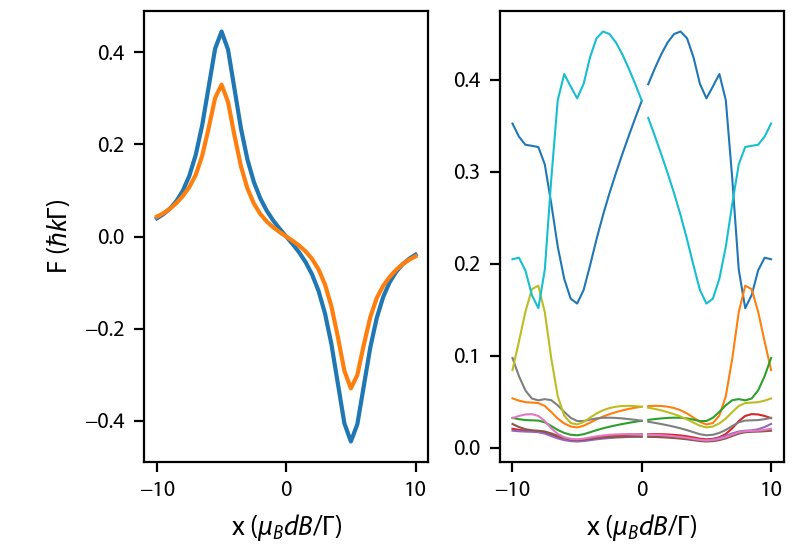

In [52]:
"""
Before we consider the grating MOT, let's consider the standard 1D MOT first:
"""
laserBeams = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'spherical', 'delta':det, 'beta':beta},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'spherical', 'delta':det, 'beta':beta},
    ])

# First, define the coordinate system:
z = np.arange(-10.0, 10.1, 0.5)
v = np.arange(-10.0, 10.1, 0.5)

trap = {}
for species in species_list:
    trap[species] = pylcp.trap_rateeq(laserBeams, magField, hamiltonian[species])
    trap[species].generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')

fig = plt.figure()
fig.set_size_inches((4,2.75))
gs = gridspec.GridSpec(1,2,wspace=0.25)

ax = [0,0]
ax[0] = fig.add_subplot(gs[0,0])
for species in species_list:
    ax[0].plot(z, trap[species].profile['Fz'].F[2])
    ax[0].set_xlabel('x ($\mu_B dB/\Gamma$)')
    ax[0].set_ylabel('F ($\hbar k \Gamma$)')

ax[1] = fig.add_subplot(gs[0,1])    
species = '$^{87}$Sr'
for ii in range(10):
    inds = trap[species].profile['Fz'].R[2] <= 0.
    ax[1].plot(trap[species].profile['Fz'].R[2][inds],
               trap[species].profile['Fz'].Neq[inds, 9-ii], color='C%d'%ii,
               linewidth=0.75)
    ax[1].plot(trap[species].profile['Fz'].R[2][np.bitwise_not(inds)],
               trap[species].profile['Fz'].Neq[np.bitwise_not(inds), ii],
               color='C%d'%ii, linewidth=0.75)
    ax[1].set_xlabel('x ($\mu_B dB/\Gamma$)')
    """ax[1].plot(trap[species].profile['Fz'].R[2],
               np.sum(trap[species].profile['Fz'].Neq, axis=1), 'k-')"""

<IPython.core.display.Javascript object>


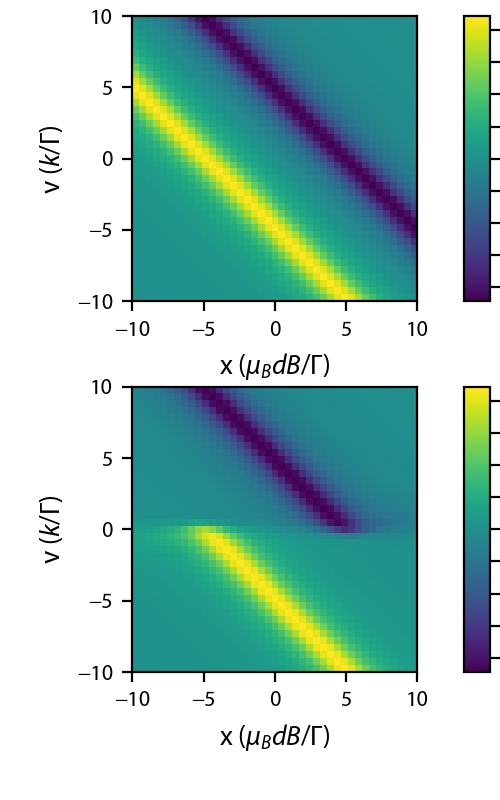

In [53]:
"""
Now, let's consider the full phase space:
"""
Z, V = np.meshgrid(z, v)
for species in species_list:
    trap[species].generate_force_profile(
        [np.zeros(Z.shape), np.zeros(Z.shape), Z],
        [np.zeros(Z.shape), np.zeros(Z.shape), V],
        name='F_Z,V')

divnorm = colors.DivergingNorm(vcenter=0)
fig = plt.figure()
fig.set_size_inches((2.5,4))
gs = gridspec.GridSpec(2,2,hspace=0.3,wspace=0.02, width_ratios=(14,1))

ax=[0,0]
cax=[0,0]
for ii, species in enumerate(species_list):
    ax[ii] = fig.add_subplot(gs[ii,0])
    cax[ii] = fig.add_subplot(gs[ii,1])
    im = ax[ii].imshow(trap[species].profile['F_Z,V'].F[2], norm=divnorm, origin='lower', \
                  extent=[np.min(v),np.max(v),np.min(v),np.max(v)], interpolation='none')
    plt.colorbar(mappable=im,cax=cax[ii])
    ax[ii].set_xlabel('x ($\mu_B dB/\Gamma$)')
    ax[ii].set_ylabel('v ($k/\Gamma$)')

<IPython.core.display.Javascript object>


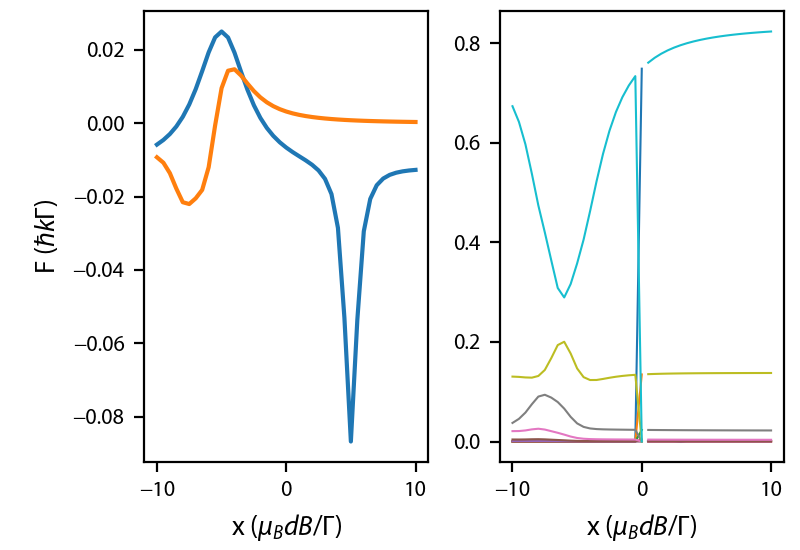

In [54]:
"""
Now, we consider the same thing, but for a grating MOT:
"""
laserBeams = grating_MOT_beams(det, beta, Nb, thd, eta=eta)

trap = {}
for species in species_list:
    trap[species] = pylcp.trap_rateeq(laserBeams, magField, hamiltonian[species])
    trap[species].generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')

fig = plt.figure()
fig.set_size_inches((4,2.75))
gs = gridspec.GridSpec(1,2,wspace=0.25)

ax = [0,0]
ax[0] = fig.add_subplot(gs[0,0])
for species in species_list:
    ax[0].plot(z, trap[species].profile['Fz'].F[2])
    ax[0].set_xlabel('x ($\mu_B dB/\Gamma$)')
    ax[0].set_ylabel('F ($\hbar k \Gamma$)')

ax[1] = fig.add_subplot(gs[0,1])    
species = '$^{87}$Sr'
for ii in range(10):
    inds = trap[species].profile['Fz'].R[2] <= 0.
    ax[1].plot(trap[species].profile['Fz'].R[2][inds],
               trap[species].profile['Fz'].Neq[inds, 9-ii], color='C%d'%ii,
               linewidth=0.75)
    ax[1].plot(trap[species].profile['Fz'].R[2][np.bitwise_not(inds)],
               trap[species].profile['Fz'].Neq[np.bitwise_not(inds), ii],
               color='C%d'%ii, linewidth=0.75)
    ax[1].set_xlabel('x ($\mu_B dB/\Gamma$)')
    """ax[1].plot(trap[species].profile['Fz'].R[2],
               np.sum(trap[species].profile['Fz'].Neq, axis=1), 'k-')"""

<IPython.core.display.Javascript object>


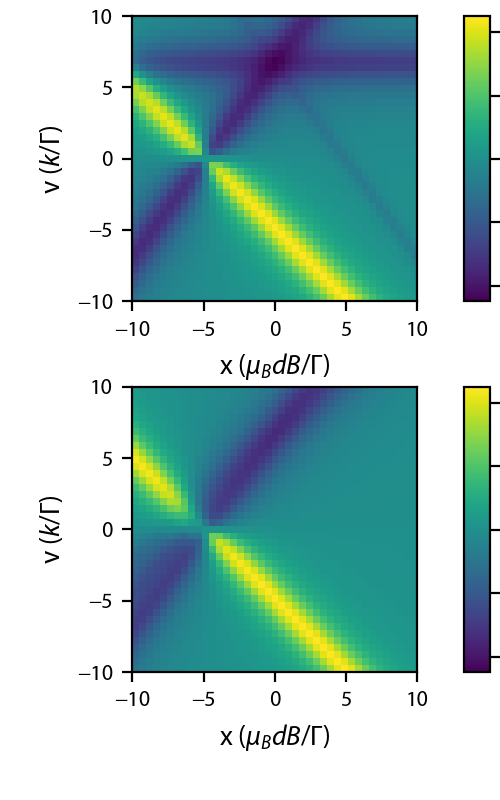

In [55]:
"""
Now, let's consider the full phase space:
"""
Z, V = np.meshgrid(z, v)
for species in species_list:
    trap[species].generate_force_profile(
        [np.zeros(Z.shape), np.zeros(Z.shape), Z],
        [np.zeros(Z.shape), np.zeros(Z.shape), V],
        name='F_Z,V')

divnorm = colors.DivergingNorm(vcenter=0)
fig = plt.figure()
fig.set_size_inches((2.5,4))
gs = gridspec.GridSpec(2,2,hspace=0.3,wspace=0.02, width_ratios=(14,1))

ax=[0,0]
cax=[0,0]
for ii, species in enumerate(species_list):
    ax[ii] = fig.add_subplot(gs[ii,0])
    cax[ii] = fig.add_subplot(gs[ii,1])
    im = ax[ii].imshow(trap[species].profile['F_Z,V'].F[2], norm=divnorm, origin='lower', \
                  extent=[np.min(v),np.max(v),np.min(v),np.max(v)], interpolation='none')
    plt.colorbar(mappable=im,cax=cax[ii])
    ax[ii].set_xlabel('x ($\mu_B dB/\Gamma$)')
    ax[ii].set_ylabel('v ($k/\Gamma$)')